In [76]:
# Download libraries
!apt update
!apt upgrade
!apt install gdal-bin python-gdal python3-gdal 
# Install rtree - Geopandas requirment
!apt install python3-rtree 
# Install Geopandas
!pip install git+git://github.com/geopandas/geopandas.git
# Install descartes - Geopandas requirment
!pip install descartes 

Ign:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:2 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:3 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Hit:4 http://archive.ubuntu.com/ubuntu bionic InRelease
Ign:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:7 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:8 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:9 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran35/ InRelease
Hit:10 http://ppa.launchpad.net/marutter/c2d4u3.5/ubuntu bionic InRelease
Get:11 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Fetched 252 kB in 2s (140 kB/s)
Reading package lists... Done
Building dependency tree       
Reading s

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point, Polygon, MultiPoint
from scipy import spatial
from shapely import wkt

In [78]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
folder = "/content/drive/My Drive/Data Science Training/YCBS 299 Data Science Capstone Project/YCBS 299 Final Project Shared/Data/"

## Load and transform incidents data

In [0]:
folder = "/content/drive/My Drive/Data Science Training/YCBS 299 Data Science Capstone Project/YCBS 299 Final Project Shared/Data/"
incidents = pd.read_csv(folder + "all_incidents_with_polygons.csv")
incidents.head()

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (28) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Unnamed: 0,CASERNE,CIV,CREATION_DATE_TIME,DESCRIPTION_GROUPE,DIVISION,INCIDENT_NBR,INCIDENT_TYPE_DESC,LATITUDE,LONGITUDE,MTM8_X,MTM8_Y,NOMBRE_UNITES,NOM_ARROND,NOM_VILLE,Description,Description Groupe Clean,geometry,index_right,ARR_DRT,ARR_GCH,CLASSE,DEB_DRT,DEB_GCH,DIR_VOIE,DIST_TO_FS,FIN_DRT,FIN_GCH,FIRE_STATION,ID_TRC,LIE_VOIE,LIM_DRT,LIM_GCH,Latitude,Longitude,NOM_VOIE,SENS_CIR,TYP_VOIE,Polygon,Intersection,CFSAUID
0,0,18,NaN,2005-01-01 00:03:47,Sans incendie,21,1,Inondation,45.620274,-73.619956,NaN,NaN,1.0,Montréal-Nord,Montréal-Nord,Inondation,Sans incendie,POINT (-73.6199555455142 45.6202743134406),61176.0,Montr�al-Nord,Montr�al-Nord,0.0,12315.0,12308.0,NaN,0.487585,12397.0,12396.0,False,1611247.0,NaN,Montr�al,Montr�al,45.619839,-73.619504,Monty,1.0,avenue,POLYGON ((-73.61969933695617 45.62113778678873...,POINT (-73.61950363 45.6198385),H1G
1,1,10,NaN,2005-01-01 00:03:56,Alarmes-incendies,18,2,Alarme privé ou locale,45.494087,-73.582587,NaN,NaN,7.0,Ville-Marie / Parc Jean-Drapeau / Centre-Sud,Montréal,Alarme privé ou locale,Alarmes-incendies,POINT (-73.5825873217504 45.4940870599786),21349.0,Ville-Marie,Ville-Marie,0.0,1819.0,1800.0,NaN,0.231986,1893.0,1850.0,False,1260379.0,NaN,Montr�al,Montr�al,45.494090,-73.582592,Lincoln,-1.0,avenue,"POLYGON ((-73.58225091503115 45.4936557281069,...",POINT (-73.58259193000001 45.49409021),H3H
2,2,72,NaN,2005-01-01 00:03:57,Alarmes-incendies,13,3,Alarme privé ou locale,45.484406,-73.693038,NaN,NaN,6.0,St-Laurent,Saint-Laurent,Alarme privé ou locale,Alarmes-incendies,POINT (-73.6930380818537 45.48440615541971),53221.0,Saint-Laurent,Saint-Laurent,8.0,0.0,0.0,NaN,4.325928,0.0,0.0,False,1606966.0,NaN,Montr�al,Montr�al,45.484477,-73.693152,520,-1.0,autoroute,POLYGON ((-73.69480992883128 45.48545914778138...,POINT (-73.6931517 45.48447684),H4R
3,3,13,NaN,2005-01-01 00:05:01,Sans incendie,23,4,Inondation,45.541383,-73.545944,NaN,NaN,1.0,Mercier / Hochelaga-Maisonneuve,Montréal,Inondation,Sans incendie,POINT (-73.54594352271809 45.5413831100549),29324.0,Mercier-Hochelaga-Maisonneuve,Mercier-Hochelaga-Maisonneuve,0.0,1801.0,1830.0,NaN,0.523710,1931.0,1884.0,False,1400499.0,NaN,Montr�al,Montr�al,45.541104,-73.545030,Saint-Germain,0.0,rue,POLYGON ((-73.54602041201372 45.54131604376335...,POINT (-73.54503004 45.54110355),H1W
4,4,18,NaN,2005-01-01 00:06:20,Sans incendie,21,5,Inondation,45.611304,-73.632440,NaN,NaN,1.0,Montréal-Nord,Montréal-Nord,Inondation,Sans incendie,POINT (-73.63243985220581 45.611304128944),59936.0,Montr�al-Nord,Montr�al-Nord,6.0,0.0,5441.0,NaN,1.295471,0.0,5527.0,False,1610847.0,NaN,Montr�al,Montr�al,45.610914,-73.632678,L�ger,-1.0,boulevard,POLYGON ((-73.63282835706556 45.61161609885908...,POINT (-73.63267786 45.6109145),H1G


In [0]:
incidents = incidents.drop(['DESCRIPTION_GROUPE','Unnamed: 0','CIV','CASERNE','DIVISION','MTM8_X','MTM8_Y','index_right','ARR_DRT','ARR_GCH',
'CLASSE','DEB_DRT','DEB_GCH','DIR_VOIE','DIST_TO_FS','FIN_DRT','FIN_GCH','FIRE_STATION','ID_TRC','LIE_VOIE','LIM_DRT',
'LIM_GCH','Latitude','Longitude','NOM_VOIE','SENS_CIR','TYP_VOIE','geometry','INCIDENT_TYPE_DESC'],axis=1,errors='ignore')

In [0]:
incidents.head()

,CREATION_DATE_TIME,INCIDENT_NBR,LATITUDE,LONGITUDE,NOMBRE_UNITES,NOM_ARROND,NOM_VILLE,Description,Description Groupe Clean,Polygon,Intersection,CFSAUID
0,2005-01-01 00:03:47,1,45.620274,-73.619956,1.0,Montréal-Nord,Montréal-Nord,Inondation,Sans incendie,POLYGON ((-73.61969933695617 45.62113778678873...,POINT (-73.61950363 45.6198385),H1G
1,2005-01-01 00:03:56,2,45.494087,-73.582587,7.0,Ville-Marie / Parc Jean-Drapeau / Centre-Sud,Montréal,Alarme privé ou locale,Alarmes-incendies,"POLYGON ((-73.58225091503115 45.4936557281069,...",POINT (-73.58259193000001 45.49409021),H3H
2,2005-01-01 00:03:57,3,45.484406,-73.693038,6.0,St-Laurent,Saint-Laurent,Alarme privé ou locale,Alarmes-incendies,POLYGON ((-73.69480992883128 45.48545914778138...,POINT (-73.6931517 45.48447684),H4R
3,2005-01-01 00:05:01,4,45.541383,-73.545944,1.0,Mercier / Hochelaga-Maisonneuve,Montréal,Inondation,Sans incendie,POLYGON ((-73.54602041201372 45.54131604376335...,POINT (-73.54503004 45.54110355),H1W
4,2005-01-01 00:06:20,5,45.611304,-73.632440,1.0,Montréal-Nord,Montréal-Nord,Inondation,Sans incendie,POLYGON ((-73.63282835706556 45.61161609885908...,POINT (-73.63267786 45.6109145),H1G


In [0]:
incidents['CREATION_DATE_TIME'] = pd.to_datetime(incidents['CREATION_DATE_TIME'])
incidents['Year'] = incidents['CREATION_DATE_TIME'].apply(lambda x: x.year)
incidents['Month'] = incidents['CREATION_DATE_TIME'].apply(lambda x: x.month)

In [0]:
incidents['Building_fire'] = incidents['Description Groupe Clean'].apply(lambda x: 1 if x == 'Incendies de bâtiments' else 0)
incidents['Building_fire'].value_counts()

0    1474789
1      20363
Name: Building_fire, dtype: int64

In [0]:
incidents['incident'] = 1

In [0]:
incidents.head()

,CREATION_DATE_TIME,INCIDENT_NBR,LATITUDE,LONGITUDE,NOMBRE_UNITES,NOM_ARROND,NOM_VILLE,Description,Description Groupe Clean,Polygon,Intersection,CFSAUID,Year,Month,Building_fire,incident
0,2005-01-01 00:03:47,1,45.620274,-73.619956,1.0,Montréal-Nord,Montréal-Nord,Inondation,Sans incendie,POLYGON ((-73.61969933695617 45.62113778678873...,POINT (-73.61950363 45.6198385),H1G,2005,1,0,1
1,2005-01-01 00:03:56,2,45.494087,-73.582587,7.0,Ville-Marie / Parc Jean-Drapeau / Centre-Sud,Montréal,Alarme privé ou locale,Alarmes-incendies,"POLYGON ((-73.58225091503115 45.4936557281069,...",POINT (-73.58259193000001 45.49409021),H3H,2005,1,0,1
2,2005-01-01 00:03:57,3,45.484406,-73.693038,6.0,St-Laurent,Saint-Laurent,Alarme privé ou locale,Alarmes-incendies,POLYGON ((-73.69480992883128 45.48545914778138...,POINT (-73.6931517 45.48447684),H4R,2005,1,0,1
3,2005-01-01 00:05:01,4,45.541383,-73.545944,1.0,Mercier / Hochelaga-Maisonneuve,Montréal,Inondation,Sans incendie,POLYGON ((-73.54602041201372 45.54131604376335...,POINT (-73.54503004 45.54110355),H1W,2005,1,0,1
4,2005-01-01 00:06:20,5,45.611304,-73.632440,1.0,Montréal-Nord,Montréal-Nord,Inondation,Sans incendie,POLYGON ((-73.63282835706556 45.61161609885908...,POINT (-73.63267786 45.6109145),H1G,2005,1,0,1


In [0]:
incidents.to_csv(folder + "clean_incidents.csv")

## Create Voronoi polygons based on each intersection in Montreal

In [80]:
df = pd.read_csv(folder + "node_data.csv",engine='python')
intersections = df[(df["DIST_TO_FS"]>=0) & (df["DIST_TO_FS"]<1000)]

geometry = [Point(xy) for xy in zip(intersections.Longitude, intersections.Latitude)]
gdf = gpd.GeoDataFrame(intersections, geometry=geometry)
gdf.head()

,Unnamed: 0,ARR_DRT,ARR_GCH,CLASSE,DEB_DRT,DEB_GCH,DIR_VOIE,DIST_TO_FS,FIN_DRT,FIN_GCH,FIRE_STATION,ID_TRC,LIE_VOIE,LIM_DRT,LIM_GCH,Latitude,Longitude,NOM_VOIE,SENS_CIR,TYP_VOIE,geometry
0,0,Ahuntsic-Cartierville,Ahuntsic-Cartierville,0,12323,12320,NaN,3.780314,12335,12340,False,1010001,NaN,Montr�al,Montr�al,45.518973,-73.740817,Adh�mar-Mailhiot,0,avenue,POINT (-73.74082 45.51897)
1,1,Ahuntsic-Cartierville,Ahuntsic-Cartierville,0,12323,12320,NaN,3.898304,12335,12340,False,1010001,NaN,Montr�al,Montr�al,45.519703,-73.741954,Adh�mar-Mailhiot,0,avenue,POINT (-73.74195 45.51970)
2,2,Ahuntsic-Cartierville,Ahuntsic-Cartierville,0,5475,5530,NaN,1.394357,5625,5570,False,1010004,NaN,Montr�al,Montr�al,45.527646,-73.706235,D'Aiguillon,0,place,POINT (-73.70624 45.52765)
25,25,Ahuntsic-Cartierville,Ahuntsic-Cartierville,0,5475,5530,NaN,1.286607,5625,5570,False,1010004,NaN,Montr�al,Montr�al,45.526991,-73.705217,D'Aiguillon,0,place,POINT (-73.70522 45.52699)
26,26,Ahuntsic-Cartierville,Ahuntsic-Cartierville,0,7745,7750,NaN,3.356020,7805,7830,False,1010005,NaN,Montr�al,Montr�al,45.524462,-73.737150,Albert-LeSage,0,avenue,POINT (-73.73715 45.52446)


In [0]:
def voronoi_finite_polygons_2d(vor, radius=None):
    """Reconstruct infinite Voronoi regions in a
    2D diagram to finite regions.
    Source:
    [https://stackoverflow.com/a/20678647/1595060](https://stackoverflow.com/a/20678647/1595060)
    """
    if vor.points.shape[1] != 2:
        raise ValueError("Requires 2D input")
    new_regions = []
    new_vertices = vor.vertices.tolist()
    center = vor.points.mean(axis=0)
    if radius is None:
        radius = vor.points.ptp().max()
    # Construct a map containing all ridges for a
    # given point
    all_ridges = {}
    for (p1, p2), (v1, v2) in zip(vor.ridge_points,
                                  vor.ridge_vertices):
        all_ridges.setdefault(
            p1, []).append((p2, v1, v2))
        all_ridges.setdefault(
            p2, []).append((p1, v1, v2))
    # Reconstruct infinite regions
    for p1, region in enumerate(vor.point_region):
        vertices = vor.regions[region]
        if all(v >= 0 for v in vertices):
            # finite region
            new_regions.append(vertices)
            continue
        # reconstruct a non-finite region
        ridges = all_ridges[p1]
        new_region = [v for v in vertices if v >= 0]
        for p2, v1, v2 in ridges:
            if v2 < 0:
                v1, v2 = v2, v1
            if v1 >= 0:
                # finite ridge: already in the region
                continue
            # Compute the missing endpoint of an
            # infinite ridge
            t = vor.points[p2] - \
                vor.points[p1]  # tangent
            t /= np.linalg.norm(t)
            n = np.array([-t[1], t[0]])  # normal
            midpoint = vor.points[[p1, p2]]. \
                mean(axis=0)
            direction = np.sign(
                np.dot(midpoint - center, n)) * n
            far_point = vor.vertices[v2] + \
                direction * radius
            new_region.append(len(new_vertices))
            new_vertices.append(far_point.tolist())
        # Sort region counterclockwise.
        vs = np.asarray([new_vertices[v]
                         for v in new_region])
        c = vs.mean(axis=0)
        angles = np.arctan2(
            vs[:, 1] - c[1], vs[:, 0] - c[0])
        new_region = np.array(new_region)[
            np.argsort(angles)]
        new_regions.append(new_region.tolist())
    return new_regions, np.asarray(new_vertices)

In [0]:
# Create voronoi polygons based on points
pts = [[x,y] for x,y in zip(intersections.Longitude, intersections.Latitude)]
vors = spatial.Voronoi(pts)

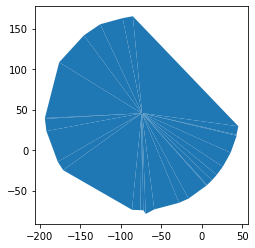

In [83]:
# Unpack regions from the voronoi polygon output
reg_idx, vertices = voronoi_finite_polygons_2d(vors)

regions = [vertices[reg] for reg in reg_idx]

crs = {'proj': 'latlong', 'ellps': 'WGS84', 'datum': 'WGS84', 'no_defs': True}

region_poly = gpd.GeoSeries([Polygon(region) for region in regions],crs = crs)
region_poly.plot()

In [84]:
# Upload the fire station territories. These will be used to create a mask for the island of Montreal
folder = "/content/drive/My Drive/Data Science Training/YCBS 299 Data Science Capstone Project/YCBS 299 Final Project Shared/Data/"
territories = gpd.read_file(folder+"territoires-administratifs-casernes.geojson",driver = 'GeoJSON')
territories['City'] = 'Montreal'
territories.head(10)

,NOM_CAS_AD,NO_CAS_ADM,OBJECTID,geometry,City
0,Caserne 72,72,296,"POLYGON ((-73.71849 45.52474, -73.71849 45.524...",Montreal
1,Caserne 71,71,297,"POLYGON ((-73.73490 45.50978, -73.73490 45.509...",Montreal
2,Caserne 32,32,298,"POLYGON ((-73.47494 45.70244, -73.47524 45.702...",Montreal
3,Caserne 25,25,299,"POLYGON ((-73.58662 45.51555, -73.58244 45.513...",Montreal
4,Caserne 31,31,300,"POLYGON ((-73.60336 45.52838, -73.60459 45.528...",Montreal
5,Caserne 59,59,301,"MULTIPOLYGON (((-73.86588 45.47124, -73.86533 ...",Montreal
6,Caserne 57,57,302,"MULTIPOLYGON (((-73.84104 45.51683, -73.84095 ...",Montreal
7,Caserne 41,41,303,"POLYGON ((-73.61610 45.53647, -73.61730 45.535...",Montreal
8,Caserne 49,49,305,"POLYGON ((-73.64314 45.55699, -73.64020 45.556...",Montreal
9,Caserne 15,15,309,"POLYGON ((-73.52721 45.48830, -73.52726 45.487...",Montreal


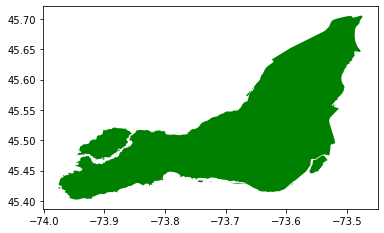

In [85]:
# Dissolve the areas into one multi polygon that spans the island of Montreal
mask = territories.dissolve(by='City')
mask['geometry'].plot(color='green')

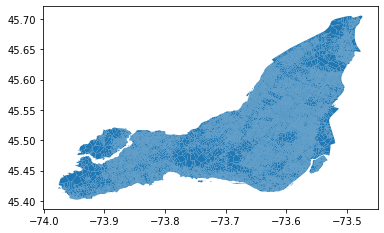

In [86]:
# Modify the Voronoi polygons to span only the island (and not continue into infinity)
new_poly_lst = []
for poly in region_poly:
  new_poly_lst.append(poly.intersection(mask.geometry[0]))

new_poly = gpd.GeoSeries(new_poly_lst)
new_poly.plot()

In [87]:
len(new_poly),len(gdf)

(25140, 25140)

In [88]:
gdf_right = gpd.GeoDataFrame(geometry=new_poly)
gdf_right['Polygon'] = gdf_right['geometry']
gdf_right.head()

,geometry,Polygon
0,"POLYGON ((-73.74012 45.51879, -73.74069 45.518...","POLYGON ((-73.74012 45.51879, -73.74069 45.518..."
1,"POLYGON ((-73.74190 45.51890, -73.74438 45.522...","POLYGON ((-73.74190 45.51890, -73.74438 45.522..."
2,"POLYGON ((-73.70526 45.52805, -73.70640 45.526...","POLYGON ((-73.70526 45.52805, -73.70640 45.526..."
3,"POLYGON ((-73.70526 45.52805, -73.70465 45.528...","POLYGON ((-73.70526 45.52805, -73.70465 45.528..."
4,"POLYGON ((-73.73796 45.52373, -73.73719 45.524...","POLYGON ((-73.73796 45.52373, -73.73719 45.524..."


In [13]:
# Join polygons with points data to retain all other information
gdf_joined = gpd.sjoin(gdf,gdf_right,how="left",op="within")
gdf_joined.head()

,Unnamed: 0,ARR_DRT,ARR_GCH,CLASSE,DEB_DRT,DEB_GCH,DIR_VOIE,DIST_TO_FS,FIN_DRT,FIN_GCH,FIRE_STATION,ID_TRC,LIE_VOIE,LIM_DRT,LIM_GCH,Latitude,Longitude,NOM_VOIE,SENS_CIR,TYP_VOIE,geometry,index_right,Polygon
0,0,Ahuntsic-Cartierville,Ahuntsic-Cartierville,0,12323,12320,NaN,3.780314,12335,12340,False,1010001,NaN,Montr�al,Montr�al,45.518973,-73.740817,Adh�mar-Mailhiot,0,avenue,POINT (-73.74082 45.51897),0.0,"POLYGON ((-73.74012 45.51879, -73.74069 45.518..."
1,1,Ahuntsic-Cartierville,Ahuntsic-Cartierville,0,12323,12320,NaN,3.898304,12335,12340,False,1010001,NaN,Montr�al,Montr�al,45.519703,-73.741954,Adh�mar-Mailhiot,0,avenue,POINT (-73.74195 45.51970),1.0,"POLYGON ((-73.74190 45.51890, -73.74438 45.522..."
2,2,Ahuntsic-Cartierville,Ahuntsic-Cartierville,0,5475,5530,NaN,1.394357,5625,5570,False,1010004,NaN,Montr�al,Montr�al,45.527646,-73.706235,D'Aiguillon,0,place,POINT (-73.70624 45.52765),2.0,"POLYGON ((-73.70526 45.52805, -73.70640 45.526..."
25,25,Ahuntsic-Cartierville,Ahuntsic-Cartierville,0,5475,5530,NaN,1.286607,5625,5570,False,1010004,NaN,Montr�al,Montr�al,45.526991,-73.705217,D'Aiguillon,0,place,POINT (-73.70522 45.52699),3.0,"POLYGON ((-73.70526 45.52805, -73.70465 45.528..."
26,26,Ahuntsic-Cartierville,Ahuntsic-Cartierville,0,7745,7750,NaN,3.356020,7805,7830,False,1010005,NaN,Montr�al,Montr�al,45.524462,-73.737150,Albert-LeSage,0,avenue,POINT (-73.73715 45.52446),4.0,"POLYGON ((-73.73796 45.52373, -73.73719 45.524..."


In [0]:
gdf_joined['Intersection'] = gdf_joined['geometry']
gdf_joined = gdf_joined.drop(['index_right'],axis=1)

## Assign each intersection to a postal code

In [15]:
postal_codes = gpd.read_file(folder + "Mtl_postal_code/mtl_postal_code.shp")
postal_codes.head()

,CFSAUID,PRUID,Prov,Population,Private_dw,Private_d2,geometry
0,H1A,24,Quebec,32516,14287,13832,"MULTIPOLYGON (((-73.47668 45.70214, -73.47722 ..."
1,H1B,24,Quebec,20160,9400,9042,"POLYGON ((-73.50219 45.65192, -73.50231 45.651..."
2,H1C,24,Quebec,14678,4734,4685,"POLYGON ((-73.50900 45.69807, -73.50900 45.698..."
3,H1E,24,Quebec,42420,16941,16437,"MULTIPOLYGON (((-73.57704 45.62832, -73.57717 ..."
4,H1G,24,Quebec,48556,21206,19661,"POLYGON ((-73.60477 45.62507, -73.60297 45.623..."


In [16]:
gdf_joined_postal = gpd.sjoin(gdf_joined,postal_codes[['CFSAUID','geometry']],how="left",op="within")
gdf_joined_postal.head()

/usr/local/lib/python3.6/dist-packages/geopandas/tools/sjoin.py:61: UserWarning: CRS of frames being joined does not match!(None != {'init': 'epsg:4326'})
  "(%s != %s)" % (left_df.crs, right_df.crs)


,Unnamed: 0,ARR_DRT,ARR_GCH,CLASSE,DEB_DRT,DEB_GCH,DIR_VOIE,DIST_TO_FS,FIN_DRT,FIN_GCH,FIRE_STATION,ID_TRC,LIE_VOIE,LIM_DRT,LIM_GCH,Latitude,Longitude,NOM_VOIE,SENS_CIR,TYP_VOIE,geometry,Polygon,Intersection,index_right,CFSAUID
0,0,Ahuntsic-Cartierville,Ahuntsic-Cartierville,0,12323,12320,NaN,3.780314,12335,12340,False,1010001,NaN,Montr�al,Montr�al,45.518973,-73.740817,Adh�mar-Mailhiot,0,avenue,POINT (-73.74082 45.51897),"POLYGON ((-73.74012 45.51879, -73.74069 45.518...",POINT (-73.74082 45.51897),67.0,H4K
1,1,Ahuntsic-Cartierville,Ahuntsic-Cartierville,0,12323,12320,NaN,3.898304,12335,12340,False,1010001,NaN,Montr�al,Montr�al,45.519703,-73.741954,Adh�mar-Mailhiot,0,avenue,POINT (-73.74195 45.51970),"POLYGON ((-73.74190 45.51890, -73.74438 45.522...",POINT (-73.74195 45.51970),67.0,H4K
2,2,Ahuntsic-Cartierville,Ahuntsic-Cartierville,0,5475,5530,NaN,1.394357,5625,5570,False,1010004,NaN,Montr�al,Montr�al,45.527646,-73.706235,D'Aiguillon,0,place,POINT (-73.70624 45.52765),"POLYGON ((-73.70526 45.52805, -73.70640 45.526...",POINT (-73.70624 45.52765),66.0,H4J
25,25,Ahuntsic-Cartierville,Ahuntsic-Cartierville,0,5475,5530,NaN,1.286607,5625,5570,False,1010004,NaN,Montr�al,Montr�al,45.526991,-73.705217,D'Aiguillon,0,place,POINT (-73.70522 45.52699),"POLYGON ((-73.70526 45.52805, -73.70465 45.528...",POINT (-73.70522 45.52699),66.0,H4J
26,26,Ahuntsic-Cartierville,Ahuntsic-Cartierville,0,7745,7750,NaN,3.356020,7805,7830,False,1010005,NaN,Montr�al,Montr�al,45.524462,-73.737150,Albert-LeSage,0,avenue,POINT (-73.73715 45.52446),"POLYGON ((-73.73796 45.52373, -73.73719 45.524...",POINT (-73.73715 45.52446),67.0,H4K


In [17]:
gdf_joined_postal[gdf_joined_postal['CFSAUID'].isnull()]

,Unnamed: 0,ARR_DRT,ARR_GCH,CLASSE,DEB_DRT,DEB_GCH,DIR_VOIE,DIST_TO_FS,FIN_DRT,FIN_GCH,FIRE_STATION,ID_TRC,LIE_VOIE,LIM_DRT,LIM_GCH,Latitude,Longitude,NOM_VOIE,SENS_CIR,TYP_VOIE,geometry,Polygon,Intersection,index_right,CFSAUID
71965,71965,Ville-Marie,Ville-Marie,5,3700,0,NaN,1.826422,3700,0,False,1614672,NaN,Montr�al,Montr�al,45.508246,-73.531775,Pierre-Dupuy,0,avenue,POINT (-73.53177 45.50825),"POLYGON ((-73.53208 45.50819, -73.53186 45.508...",POINT (-73.53177 45.50825),NaN,NaN
111461,111461,Ville-Marie,Ville-Marie,5,0,0,NaN,1.958934,0,0,False,4006504,NaN,Montr�al,Montr�al,45.508050,-73.530075,Pierre-Dupuy,-1,avenue,POINT (-73.53008 45.50805),"POLYGON ((-73.53108 45.50678, -73.53078 45.509...",POINT (-73.53008 45.50805),NaN,NaN
114622,114622,NaN,NaN,8,0,0,NaN,1.739567,0,0,False,4007575,NaN,Sainte-Anne-de-Bellevue,Sainte-Anne-de-Bellevue,45.403508,-73.955590,Galipeault,1,pont,POINT (-73.95559 45.40351),None,POINT (-73.95559 45.40351),NaN,NaN


In [18]:
# Fill empty postal codes manually
gdf_joined_postal.loc[(gdf_joined_postal['CFSAUID'].isnull())&(gdf_joined_postal['NOM_VOIE'] == 'Pierre-Dupuy'), 'CFSAUID'] = 'H3C'
gdf_joined_postal.loc[(gdf_joined_postal['CFSAUID'].isnull())&(gdf_joined_postal['NOM_VOIE'] == 'Galipeault'), 'CFSAUID'] = 'H9X'
gdf_joined_postal[gdf_joined_postal['CFSAUID'].isnull()]

,Unnamed: 0,ARR_DRT,ARR_GCH,CLASSE,DEB_DRT,DEB_GCH,DIR_VOIE,DIST_TO_FS,FIN_DRT,FIN_GCH,FIRE_STATION,ID_TRC,LIE_VOIE,LIM_DRT,LIM_GCH,Latitude,Longitude,NOM_VOIE,SENS_CIR,TYP_VOIE,geometry,Polygon,Intersection,index_right,CFSAUID


In [19]:
polygon_data = gdf_joined_postal[['Polygon','Intersection','CFSAUID']]
polygon_data.head()

,Polygon,Intersection,CFSAUID
0,"POLYGON ((-73.74012 45.51879, -73.74069 45.518...",POINT (-73.74082 45.51897),H4K
1,"POLYGON ((-73.74190 45.51890, -73.74438 45.522...",POINT (-73.74195 45.51970),H4K
2,"POLYGON ((-73.70526 45.52805, -73.70640 45.526...",POINT (-73.70624 45.52765),H4J
25,"POLYGON ((-73.70526 45.52805, -73.70465 45.528...",POINT (-73.70522 45.52699),H4J
26,"POLYGON ((-73.73796 45.52373, -73.73719 45.524...",POINT (-73.73715 45.52446),H4K


In [20]:
polygon_data[polygon_data['Polygon'].isnull()]

,Polygon,Intersection,CFSAUID
114622,None,POINT (-73.95559 45.40351),H9X


In [0]:
polygon_data.to_csv(folder + "clean_polygons",index=False)

In [22]:
len(polygon_data)

25140

## Join incidents to the corresponding polygon/year

In [0]:
# Restart code from here
incidents = pd.read_csv(folder + "clean_incidents.csv")
incidents.head()

,Unnamed: 0,CREATION_DATE_TIME,INCIDENT_NBR,LATITUDE,LONGITUDE,NOMBRE_UNITES,NOM_ARROND,NOM_VILLE,Description,Description Groupe Clean,Polygon,Intersection,CFSAUID,Year,Month,Building_fire,incident
0,0,2005-01-01 00:03:47,1,45.620274,-73.619956,1.0,Montréal-Nord,Montréal-Nord,Inondation,Sans incendie,POLYGON ((-73.61969933695617 45.62113778678873...,POINT (-73.61950363 45.6198385),H1G,2005,1,0,1
1,1,2005-01-01 00:03:56,2,45.494087,-73.582587,7.0,Ville-Marie / Parc Jean-Drapeau / Centre-Sud,Montréal,Alarme privé ou locale,Alarmes-incendies,"POLYGON ((-73.58225091503115 45.4936557281069,...",POINT (-73.58259193000001 45.49409021),H3H,2005,1,0,1
2,2,2005-01-01 00:03:57,3,45.484406,-73.693038,6.0,St-Laurent,Saint-Laurent,Alarme privé ou locale,Alarmes-incendies,POLYGON ((-73.69480992883128 45.48545914778138...,POINT (-73.6931517 45.48447684),H4R,2005,1,0,1
3,3,2005-01-01 00:05:01,4,45.541383,-73.545944,1.0,Mercier / Hochelaga-Maisonneuve,Montréal,Inondation,Sans incendie,POLYGON ((-73.54602041201372 45.54131604376335...,POINT (-73.54503004 45.54110355),H1W,2005,1,0,1
4,4,2005-01-01 00:06:20,5,45.611304,-73.632440,1.0,Montréal-Nord,Montréal-Nord,Inondation,Sans incendie,POLYGON ((-73.63282835706556 45.61161609885908...,POINT (-73.63267786 45.6109145),H1G,2005,1,0,1


In [0]:
polygon_data = pd.read_csv(folder + "clean_polygons")
polygon_data.head()

,Polygon,Intersection,CFSAUID
0,POLYGON ((-73.74012023460041 45.51878665964649...,POINT (-73.74081689 45.51897292),H4K
1,POLYGON ((-73.74189788165314 45.51889712350253...,POINT (-73.7419541 45.51970333),H4K
2,POLYGON ((-73.70525689377537 45.52804800599577...,POINT (-73.7062353 45.52764649),H4J
3,POLYGON ((-73.70525689377537 45.52804800599577...,POINT (-73.705217 45.52699117),H4J
4,POLYGON ((-73.73795586548214 45.52372803686956...,POINT (-73.73715005 45.52446169),H4K


In [0]:
polygon_year = polygon_data.copy()
polygon_year['Year'] = 2005

years = np.arange(2006,2019+1)

for year in years:
  df_tmp = polygon_data.copy()
  df_tmp['Year'] = year
  polygon_year = polygon_year.append(df_tmp)

polygon_year = polygon_year.reset_index(drop=True)
polygon_year['Year'].value_counts()

2019    25140
2018    25140
2017    25140
2016    25140
2015    25140
2014    25140
2013    25140
2012    25140
2011    25140
2010    25140
2009    25140
2008    25140
2007    25140
2006    25140
2005    25140
Name: Year, dtype: int64

In [0]:
polygon_year['Poly_Key'] = polygon_year['Polygon'].apply(lambda x: str(x))
polygon_year['Poly_Key']

0         POLYGON ((-73.74012023460041 45.51878665964649...
1         POLYGON ((-73.74189788165314 45.51889712350253...
2         POLYGON ((-73.70525689377537 45.52804800599577...
3         POLYGON ((-73.70525689377537 45.52804800599577...
4         POLYGON ((-73.73795586548214 45.52372803686956...
                                ...                        
377095    POLYGON ((-73.62723814853194 45.45084237636283...
377096    POLYGON ((-73.62654348815092 45.45247904817305...
377097    POLYGON ((-73.66477130539421 45.53503903552225...
377098    POLYGON ((-73.66574518663616 45.53255304022955...
377099    POLYGON ((-73.6054035011919 45.46714233072869,...
Name: Poly_Key, Length: 377100, dtype: object

In [0]:
incident_polygons = polygon_year.merge(incidents, how = 'left', left_on = ['Poly_Key','Year'],right_on = ['Polygon','Year'],suffixes = ('','_y'))
incident_polygons.head()

,Polygon,Intersection,CFSAUID,Year,Poly_Key,Unnamed: 0,CREATION_DATE_TIME,INCIDENT_NBR,LATITUDE,LONGITUDE,NOMBRE_UNITES,NOM_ARROND,NOM_VILLE,Description,Description Groupe Clean,Polygon_y,Intersection_y,CFSAUID_y,Month,Building_fire,incident
0,POLYGON ((-73.74012023460041 45.51878665964649...,POINT (-73.74081689 45.51897292),H4K,2005,POLYGON ((-73.74012023460041 45.51878665964649...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,POLYGON ((-73.74189788165314 45.51889712350253...,POINT (-73.7419541 45.51970333),H4K,2005,POLYGON ((-73.74189788165314 45.51889712350253...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,POLYGON ((-73.70525689377537 45.52804800599577...,POINT (-73.7062353 45.52764649),H4J,2005,POLYGON ((-73.70525689377537 45.52804800599577...,31560.0,2005-08-20 20:55:44,32071.0,45.528445,-73.706411,3.0,Ahuntsic / Cartierville,Montréal,Service non requis pour une intervention bâtiment,Sans incendie,POLYGON ((-73.70525689377537 45.52804800599577...,POINT (-73.7062353 45.52764649),H4J,8.0,0.0,1.0
3,POLYGON ((-73.70525689377537 45.52804800599577...,POINT (-73.705217 45.52699117),H4J,2005,POLYGON ((-73.70525689377537 45.52804800599577...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,POLYGON ((-73.73795586548214 45.52372803686956...,POINT (-73.73715005 45.52446169),H4K,2005,POLYGON ((-73.73795586548214 45.52372803686956...,11750.0,2005-04-03 06:07:21,11911.0,45.524286,-73.737366,27.0,Ahuntsic / Cartierville,Montréal,Feu / Agravation possible,Incendies de bâtiments,POLYGON ((-73.73795586548214 45.52372803686956...,POINT (-73.73715005 45.52446169),H4K,4.0,1.0,1.0


In [0]:
print(incident_polygons['incident'].value_counts())
print(len(incidents))

1.0    1494483
Name: incident, dtype: int64
1495152


In [0]:
incident_polygons = incident_polygons.drop(['Polygon_y','Intersection_y','CFSAUID_y','geometry'],axis=1,errors='ignore')
incident_polygons[['Building_fire','incident']] = incident_polygons[['Building_fire','incident']].fillna(0)
incident_polygons.head()

,Polygon,Intersection,CFSAUID,Year,Poly_Key,Unnamed: 0,CREATION_DATE_TIME,INCIDENT_NBR,LATITUDE,LONGITUDE,NOMBRE_UNITES,NOM_ARROND,NOM_VILLE,Description,Description Groupe Clean,Month,Building_fire,incident
0,POLYGON ((-73.74012023460041 45.51878665964649...,POINT (-73.74081689 45.51897292),H4K,2005,POLYGON ((-73.74012023460041 45.51878665964649...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0
1,POLYGON ((-73.74189788165314 45.51889712350253...,POINT (-73.7419541 45.51970333),H4K,2005,POLYGON ((-73.74189788165314 45.51889712350253...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0
2,POLYGON ((-73.70525689377537 45.52804800599577...,POINT (-73.7062353 45.52764649),H4J,2005,POLYGON ((-73.70525689377537 45.52804800599577...,31560.0,2005-08-20 20:55:44,32071.0,45.528445,-73.706411,3.0,Ahuntsic / Cartierville,Montréal,Service non requis pour une intervention bâtiment,Sans incendie,8.0,0.0,1.0
3,POLYGON ((-73.70525689377537 45.52804800599577...,POINT (-73.705217 45.52699117),H4J,2005,POLYGON ((-73.70525689377537 45.52804800599577...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0
4,POLYGON ((-73.73795586548214 45.52372803686956...,POINT (-73.73715005 45.52446169),H4K,2005,POLYGON ((-73.73795586548214 45.52372803686956...,11750.0,2005-04-03 06:07:21,11911.0,45.524286,-73.737366,27.0,Ahuntsic / Cartierville,Montréal,Feu / Agravation possible,Incendies de bâtiments,4.0,1.0,1.0


In [0]:
# Aggregate at the polygon/year 
incident_polygons['Desc_gr_clean'] = incident_polygons['Description Groupe Clean']
incident_polygons2 = pd.get_dummies(incident_polygons, columns=['Desc_gr_clean'])
incident_polygons2 = incident_polygons2.drop(['Desc_gr_clean_Incendies de bâtiments'],axis=1)
incident_polygons2['Num_units_total'] = incident_polygons2['NOMBRE_UNITES']
incident_polygons2['Num_units_mean'] = incident_polygons2['NOMBRE_UNITES']
incident_polygons2['Num_units_median'] = incident_polygons2['NOMBRE_UNITES']

incident_polygons2.head()

,Polygon,Intersection,CFSAUID,Year,Poly_Key,Unnamed: 0,CREATION_DATE_TIME,INCIDENT_NBR,LATITUDE,LONGITUDE,NOMBRE_UNITES,NOM_ARROND,NOM_VILLE,Description,Description Groupe Clean,Month,Building_fire,incident,Desc_gr_clean_Alarmes-incendies,Desc_gr_clean_Autres incendies,Desc_gr_clean_Fausses alertes/annulations,Desc_gr_clean_Nouveau,Desc_gr_clean_Premier répondant,Desc_gr_clean_Sans incendie,Num_units_total,Num_units_mean,Num_units_median
0,POLYGON ((-73.74012023460041 45.51878665964649...,POINT (-73.74081689 45.51897292),H4K,2005,POLYGON ((-73.74012023460041 45.51878665964649...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0,0,0,0,0,0,NaN,NaN,NaN
1,POLYGON ((-73.74189788165314 45.51889712350253...,POINT (-73.7419541 45.51970333),H4K,2005,POLYGON ((-73.74189788165314 45.51889712350253...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0,0,0,0,0,0,NaN,NaN,NaN
2,POLYGON ((-73.70525689377537 45.52804800599577...,POINT (-73.7062353 45.52764649),H4J,2005,POLYGON ((-73.70525689377537 45.52804800599577...,31560.0,2005-08-20 20:55:44,32071.0,45.528445,-73.706411,3.0,Ahuntsic / Cartierville,Montréal,Service non requis pour une intervention bâtiment,Sans incendie,8.0,0.0,1.0,0,0,0,0,0,1,3.0,3.0,3.0
3,POLYGON ((-73.70525689377537 45.52804800599577...,POINT (-73.705217 45.52699117),H4J,2005,POLYGON ((-73.70525689377537 45.52804800599577...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0,0,0,0,0,0,NaN,NaN,NaN
4,POLYGON ((-73.73795586548214 45.52372803686956...,POINT (-73.73715005 45.52446169),H4K,2005,POLYGON ((-73.73795586548214 45.52372803686956...,11750.0,2005-04-03 06:07:21,11911.0,45.524286,-73.737366,27.0,Ahuntsic / Cartierville,Montréal,Feu / Agravation possible,Incendies de bâtiments,4.0,1.0,1.0,0,0,0,0,0,0,27.0,27.0,27.0


In [0]:
incident_polygons_agg = incident_polygons2.groupby(['Poly_Key','CFSAUID','Year']).agg({
    'Building_fire':'sum',
 'incident':'sum',
 'Desc_gr_clean_Alarmes-incendies':'sum',
 'Desc_gr_clean_Autres incendies':'sum',
 'Desc_gr_clean_Fausses alertes/annulations':'sum',
 'Desc_gr_clean_Nouveau':'sum',
 'Desc_gr_clean_Premier répondant':'sum',
 'Desc_gr_clean_Sans incendie':'sum',
 'Num_units_total':'sum',
 'Num_units_mean':'mean',
 'Num_units_median':'median'
}).reset_index()
num_cols = ['Building_fire', 'incident','Desc_gr_clean_Alarmes-incendies','Desc_gr_clean_Autres incendies','Desc_gr_clean_Fausses alertes/annulations','Desc_gr_clean_Nouveau',
                       'Desc_gr_clean_Premier répondant','Desc_gr_clean_Sans incendie','Num_units_total','Num_units_mean','Num_units_median']
incident_polygons_agg[num_cols] = incident_polygons_agg[num_cols].fillna(0)

len(incident_polygons_agg),len(polygon_year)

(377100, 377100)

In [0]:
incident_polygons_agg.head()

,Poly_Key,CFSAUID,Year,Building_fire,incident,Desc_gr_clean_Alarmes-incendies,Desc_gr_clean_Autres incendies,Desc_gr_clean_Fausses alertes/annulations,Desc_gr_clean_Nouveau,Desc_gr_clean_Premier répondant,Desc_gr_clean_Sans incendie,Num_units_total,Num_units_mean,Num_units_median
0,MULTIPOLYGON (((-73.49148128488116 45.63322546...,H1B,2005,0.0,3.0,0,0,1,0,0.0,2,10.0,3.333333,4.0
1,MULTIPOLYGON (((-73.49148128488116 45.63322546...,H1B,2006,0.0,0.0,0,0,0,0,0.0,0,0.0,0.000000,0.0
2,MULTIPOLYGON (((-73.49148128488116 45.63322546...,H1B,2007,0.0,0.0,0,0,0,0,0.0,0,0.0,0.000000,0.0
3,MULTIPOLYGON (((-73.49148128488116 45.63322546...,H1B,2008,0.0,3.0,0,0,0,0,3.0,0,3.0,1.000000,1.0
4,MULTIPOLYGON (((-73.49148128488116 45.63322546...,H1B,2009,0.0,2.0,0,1,0,0,1.0,0,2.0,1.000000,1.0


In [0]:
incident_polygons_agg.to_csv(folder + "clean_incidents_by_polygon_year.csv")

## Add census data

In [0]:
# If skipping the previous section, reload incident polygon data:
incident_polygons_agg = pd.read_csv(folder + "clean_incidents_by_polygon_year.csv")

In [23]:
census = pd.read_csv(folder + "2005_to_2020_data_v2.csv")
census.head()

,code,year,0-4 years,5-9 years,10-14 years,15-19 years,20-24 years,25-34 years,35-44 years,45-54 years,55-64 years,65+ years,1 child,2 children,3 or more children,Common-law couples,Female parent,Male parent,Married couples,2 persons,3 persons,4 persons,5 or more persons,Couples with children,Couples without children,population,total_dwellings,income_population,total_income,Gr1 less $34999,Gr2 $35000 to $69999,Gr3 more $70000,gr1_less_34999$,gr2_35000_69999$,gr3_more_70000,gr_0_4_years,gr_5_9_years,gr_10_14_years,gr_15_19_years,gr_20_24_years,gr_25_34_years,gr_35_44_years,gr_45_54_years,gr_55_64_years,gr_65plus_years,gr_1_child,gr_2_children,gr_3_or_more_children,gr_Common_law_couples,gr_Female_parent,gr_Male_parent,gr_Married_couples,gr_2_persons,gr_3_persons,gr_4_persons,gr_5_or more persons,gr_Couples_with_children,gr_Couples_without_children,single,gr_single
0,H5A,2016,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0,0.00
1,H9C,2016,515,645,750,885,815,950,1350,2035,1980,3325,885,1005,345,650,300,120,2285,2620,1595,1775,715,1820,1115,11613,4130,9390,536025984,4220,2700,2460,0.45,0.29,0.26,0.04,0.06,0.06,0.08,0.07,0.08,0.12,0.18,0.17,0.29,0.08,0.09,0.03,0.06,0.03,0.01,0.20,0.23,0.14,0.15,0.06,0.16,0.10,3740,0.32
2,H3M,2016,875,895,775,820,840,1625,2145,2210,1830,7927,1195,1075,490,415,640,120,2900,3515,1880,1810,1015,2000,1310,15478,6716,12300,457505984,7990,2680,1650,0.65,0.22,0.13,0.06,0.06,0.05,0.05,0.05,0.10,0.14,0.14,0.12,0.51,0.08,0.07,0.03,0.03,0.04,0.01,0.19,0.23,0.12,0.12,0.07,0.13,0.08,6105,0.39
3,H3V,2016,285,190,140,235,635,1485,1005,600,620,3322,455,190,60,280,205,35,870,1950,715,320,110,470,685,6648,4515,5430,197128000,3300,1400,740,0.61,0.26,0.14,0.04,0.03,0.02,0.04,0.10,0.22,0.15,0.09,0.09,0.50,0.07,0.03,0.01,0.04,0.03,0.01,0.13,0.29,0.11,0.05,0.02,0.07,0.10,3615,0.54
4,H4Z,2016,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,10,5,0,0,0,0,0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0,0.00


In [0]:
# census['income_per_capita']= census['total_income']/census['total']
# census['Income_0_to_35K'] = census['gr1']
# census['Income_35K_to_70K'] = census['gr2']
# census['Income_70K+'] = census['gr3']
# census['population tax payers'] = census['total']
census['geo_code'] = census['code']
census['income_per_capita']= census['total_income']/census['income_population']
census['Income_0_to_35K'] = census['Gr1 less $34999']
census['Income_35K_to_70K'] = census['Gr2 $35000 to $69999']
census['Income_70K+'] = census['Gr3 more $70000']
census['population tax payers'] = census['income_population']
census['gr_0_to_14_years'] = census['gr_0_4_years'] + census['gr_5_9_years'] + census['gr_10_14_years']
census['gr_married_commomlawpartner'] = census['gr_Common_law_couples'] + census['gr_Married_couples']

In [0]:
census_clean = census[
    ['geo_code',
 'year',
 'population',
 'total_dwellings',
 'gr_0_to_14_years',
 'gr_15_19_years',
 'gr_20_24_years',
 'gr_25_34_years',
 'gr_35_44_years',
 'gr_45_54_years',
 'gr_55_64_years',
 'gr_65plus_years',
 'gr_married_commomlawpartner',
 'gr_single',
 'gr_Couples_with_children',
 'gr_Couples_without_children',
 'income_per_capita',
 'Income_0_to_35K',
 'Income_35K_to_70K',
 'Income_70K+',
 'population tax payers']
]

In [26]:
census_clean.head()

,geo_code,year,population,total_dwellings,gr_0_to_14_years,gr_15_19_years,gr_20_24_years,gr_25_34_years,gr_35_44_years,gr_45_54_years,gr_55_64_years,gr_65plus_years,gr_married_commomlawpartner,gr_single,gr_Couples_with_children,gr_Couples_without_children,income_per_capita,Income_0_to_35K,Income_35K_to_70K,Income_70K+,population tax payers
0,H5A,2016,0,0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,NaN,0,0,0,0
1,H9C,2016,11613,4130,0.16,0.08,0.07,0.08,0.12,0.18,0.17,0.29,0.26,0.32,0.16,0.10,57084.769329,4220,2700,2460,9390
2,H3M,2016,15478,6716,0.17,0.05,0.05,0.10,0.14,0.14,0.12,0.51,0.22,0.39,0.13,0.08,37195.608455,7990,2680,1650,12300
3,H3V,2016,6648,4515,0.09,0.04,0.10,0.22,0.15,0.09,0.09,0.50,0.17,0.54,0.07,0.10,36303.499079,3300,1400,740,5430
4,H4Z,2016,10,5,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,NaN,0,0,0,0


In [29]:
polygons_census = incident_polygons_agg.merge(census_clean, left_on=['CFSAUID','Year'],right_on=['geo_code','year'])
polygons_census.head()

,Unnamed: 0,Poly_Key,CFSAUID,Year,Building_fire,incident,Desc_gr_clean_Alarmes-incendies,Desc_gr_clean_Autres incendies,Desc_gr_clean_Fausses alertes/annulations,Desc_gr_clean_Nouveau,Desc_gr_clean_Premier répondant,Desc_gr_clean_Sans incendie,Num_units_total,Num_units_mean,Num_units_median,geo_code,year,population,total_dwellings,gr_0_to_14_years,gr_15_19_years,gr_20_24_years,gr_25_34_years,gr_35_44_years,gr_45_54_years,gr_55_64_years,gr_65plus_years,gr_married_commomlawpartner,gr_single,gr_Couples_with_children,gr_Couples_without_children,income_per_capita,Income_0_to_35K,Income_35K_to_70K,Income_70K+,population tax payers
0,0,MULTIPOLYGON (((-73.49148128488116 45.63322546...,H1B,2005,0.0,3.0,0,0,1,0,0.0,2,10.0,3.333333,4.0,H1B,2005,20253,8948,0.13,0.08,0.08,0.1,0.11,0.22,0.12,0.0,0.21,0.1,0.0,0.11,34781.076809,9440,5220,1520,16170
1,15,MULTIPOLYGON (((-73.49417600555641 45.63484983...,H1B,2005,0.0,0.0,0,0,0,0,0.0,0,0.0,0.000000,0.0,H1B,2005,20253,8948,0.13,0.08,0.08,0.1,0.11,0.22,0.12,0.0,0.21,0.1,0.0,0.11,34781.076809,9440,5220,1520,16170
2,30,MULTIPOLYGON (((-73.4974204148789 45.628545266...,H1B,2005,0.0,2.0,0,0,0,0,0.0,2,3.0,1.500000,1.5,H1B,2005,20253,8948,0.13,0.08,0.08,0.1,0.11,0.22,0.12,0.0,0.21,0.1,0.0,0.11,34781.076809,9440,5220,1520,16170
3,45,MULTIPOLYGON (((-73.49743783438723 45.62877001...,H1B,2005,0.0,3.0,1,0,0,0,0.0,2,7.0,2.333333,1.0,H1B,2005,20253,8948,0.13,0.08,0.08,0.1,0.11,0.22,0.12,0.0,0.21,0.1,0.0,0.11,34781.076809,9440,5220,1520,16170
4,60,MULTIPOLYGON (((-73.49952224636007 45.62478531...,H1B,2005,0.0,0.0,0,0,0,0,0.0,0,0.0,0.000000,0.0,H1B,2005,20253,8948,0.13,0.08,0.08,0.1,0.11,0.22,0.12,0.0,0.21,0.1,0.0,0.11,34781.076809,9440,5220,1520,16170


In [30]:
print(len(polygons_census[polygons_census['geo_code'].isnull()]))
print(len(polygons_census),len(incident_polygons_agg))

0
377100 377100


In [31]:
polygons_census = polygons_census.drop(['geo_code','year'],axis=1,errors='ignore')
polygons_census.head()

,Unnamed: 0,Poly_Key,CFSAUID,Year,Building_fire,incident,Desc_gr_clean_Alarmes-incendies,Desc_gr_clean_Autres incendies,Desc_gr_clean_Fausses alertes/annulations,Desc_gr_clean_Nouveau,Desc_gr_clean_Premier répondant,Desc_gr_clean_Sans incendie,Num_units_total,Num_units_mean,Num_units_median,population,total_dwellings,gr_0_to_14_years,gr_15_19_years,gr_20_24_years,gr_25_34_years,gr_35_44_years,gr_45_54_years,gr_55_64_years,gr_65plus_years,gr_married_commomlawpartner,gr_single,gr_Couples_with_children,gr_Couples_without_children,income_per_capita,Income_0_to_35K,Income_35K_to_70K,Income_70K+,population tax payers
0,0,MULTIPOLYGON (((-73.49148128488116 45.63322546...,H1B,2005,0.0,3.0,0,0,1,0,0.0,2,10.0,3.333333,4.0,20253,8948,0.13,0.08,0.08,0.1,0.11,0.22,0.12,0.0,0.21,0.1,0.0,0.11,34781.076809,9440,5220,1520,16170
1,15,MULTIPOLYGON (((-73.49417600555641 45.63484983...,H1B,2005,0.0,0.0,0,0,0,0,0.0,0,0.0,0.000000,0.0,20253,8948,0.13,0.08,0.08,0.1,0.11,0.22,0.12,0.0,0.21,0.1,0.0,0.11,34781.076809,9440,5220,1520,16170
2,30,MULTIPOLYGON (((-73.4974204148789 45.628545266...,H1B,2005,0.0,2.0,0,0,0,0,0.0,2,3.0,1.500000,1.5,20253,8948,0.13,0.08,0.08,0.1,0.11,0.22,0.12,0.0,0.21,0.1,0.0,0.11,34781.076809,9440,5220,1520,16170
3,45,MULTIPOLYGON (((-73.49743783438723 45.62877001...,H1B,2005,0.0,3.0,1,0,0,0,0.0,2,7.0,2.333333,1.0,20253,8948,0.13,0.08,0.08,0.1,0.11,0.22,0.12,0.0,0.21,0.1,0.0,0.11,34781.076809,9440,5220,1520,16170
4,60,MULTIPOLYGON (((-73.49952224636007 45.62478531...,H1B,2005,0.0,0.0,0,0,0,0,0.0,0,0.0,0.000000,0.0,20253,8948,0.13,0.08,0.08,0.1,0.11,0.22,0.12,0.0,0.21,0.1,0.0,0.11,34781.076809,9440,5220,1520,16170


In [0]:
polygons_census.to_csv(folder + "clean_incidents_by_polygon_year_census.csv")

## Add boroughs data

In [39]:
boroughs = gpd.read_file(folder + "limadmin-shp/LIMADMIN.shp")
boroughs.head()

,MUNID,CODEID,CODEMAMROT,NOM,TYPE,ABREV,NUM,AIRE,PERIM,geometry
0,66023,11,REM05,Outremont,Arrondissement,OM,5,3.813356e+06,10836.670,"POLYGON ((-73.62078 45.52365, -73.62020 45.524..."
1,66023,22,REM17,LaSalle,Arrondissement,LS,18,2.519727e+07,25259.849,"POLYGON ((-73.66610 45.42180, -73.66601 45.428..."
2,66023,62,66072,Mont-Royal,Ville liée,MR,2,7.445560e+06,18314.038,"POLYGON ((-73.65075 45.52631, -73.65036 45.526..."
3,66023,9,REM19,Ville-Marie,Arrondissement,VM,20,2.150063e+07,26585.959,"POLYGON ((-73.53013 45.53476, -73.53019 45.534..."
4,66023,5,REM21,Le Plateau-Mont-Royal,Arrondissement,PM,22,8.151665e+06,13158.328,"POLYGON ((-73.55923 45.53990, -73.56017 45.538..."


In [40]:
boroughs_clean = boroughs[['NOM','geometry']]
boroughs_clean.head()

,NOM,geometry
0,Outremont,"POLYGON ((-73.62078 45.52365, -73.62020 45.524..."
1,LaSalle,"POLYGON ((-73.66610 45.42180, -73.66601 45.428..."
2,Mont-Royal,"POLYGON ((-73.65075 45.52631, -73.65036 45.526..."
3,Ville-Marie,"POLYGON ((-73.53013 45.53476, -73.53019 45.534..."
4,Le Plateau-Mont-Royal,"POLYGON ((-73.55923 45.53990, -73.56017 45.538..."


In [41]:
polygon_data_arrond =  gdf_joined_postal[['Polygon','Intersection','geometry','CFSAUID','ARR_DRT','ARR_GCH','LIM_DRT','LIM_GCH']]
polygon_data_arrond.head()

,Polygon,Intersection,geometry,CFSAUID,ARR_DRT,ARR_GCH,LIM_DRT,LIM_GCH
0,"POLYGON ((-73.74012 45.51879, -73.74069 45.518...",POINT (-73.74082 45.51897),POINT (-73.74082 45.51897),H4K,Ahuntsic-Cartierville,Ahuntsic-Cartierville,Montr�al,Montr�al
1,"POLYGON ((-73.74190 45.51890, -73.74438 45.522...",POINT (-73.74195 45.51970),POINT (-73.74195 45.51970),H4K,Ahuntsic-Cartierville,Ahuntsic-Cartierville,Montr�al,Montr�al
2,"POLYGON ((-73.70526 45.52805, -73.70640 45.526...",POINT (-73.70624 45.52765),POINT (-73.70624 45.52765),H4J,Ahuntsic-Cartierville,Ahuntsic-Cartierville,Montr�al,Montr�al
25,"POLYGON ((-73.70526 45.52805, -73.70465 45.528...",POINT (-73.70522 45.52699),POINT (-73.70522 45.52699),H4J,Ahuntsic-Cartierville,Ahuntsic-Cartierville,Montr�al,Montr�al
26,"POLYGON ((-73.73796 45.52373, -73.73719 45.524...",POINT (-73.73715 45.52446),POINT (-73.73715 45.52446),H4K,Ahuntsic-Cartierville,Ahuntsic-Cartierville,Montr�al,Montr�al


In [42]:
polygons_boroughs = gpd.sjoin(polygon_data_arrond,boroughs_clean,how="left",op="within")
polygons_boroughs.head()

/usr/local/lib/python3.6/dist-packages/geopandas/tools/sjoin.py:61: UserWarning: CRS of frames being joined does not match!(None != {'init': 'epsg:4326'})
  "(%s != %s)" % (left_df.crs, right_df.crs)


,Polygon,Intersection,geometry,CFSAUID,ARR_DRT,ARR_GCH,LIM_DRT,LIM_GCH,index_right,NOM
0,"POLYGON ((-73.74012 45.51879, -73.74069 45.518...",POINT (-73.74082 45.51897),POINT (-73.74082 45.51897),H4K,Ahuntsic-Cartierville,Ahuntsic-Cartierville,Montr�al,Montr�al,15,Ahuntsic-Cartierville
1,"POLYGON ((-73.74190 45.51890, -73.74438 45.522...",POINT (-73.74195 45.51970),POINT (-73.74195 45.51970),H4K,Ahuntsic-Cartierville,Ahuntsic-Cartierville,Montr�al,Montr�al,15,Ahuntsic-Cartierville
2,"POLYGON ((-73.70526 45.52805, -73.70640 45.526...",POINT (-73.70624 45.52765),POINT (-73.70624 45.52765),H4J,Ahuntsic-Cartierville,Ahuntsic-Cartierville,Montr�al,Montr�al,15,Ahuntsic-Cartierville
25,"POLYGON ((-73.70526 45.52805, -73.70465 45.528...",POINT (-73.70522 45.52699),POINT (-73.70522 45.52699),H4J,Ahuntsic-Cartierville,Ahuntsic-Cartierville,Montr�al,Montr�al,15,Ahuntsic-Cartierville
26,"POLYGON ((-73.73796 45.52373, -73.73719 45.524...",POINT (-73.73715 45.52446),POINT (-73.73715 45.52446),H4K,Ahuntsic-Cartierville,Ahuntsic-Cartierville,Montr�al,Montr�al,15,Ahuntsic-Cartierville


In [43]:
len(polygon_data_arrond),len(polygons_boroughs), len(polygons_boroughs[polygons_boroughs['NOM'].isnull()])

(25140, 25140, 0)

In [44]:
polygons_boroughs['Poly_key'] = polygons_boroughs['Polygon'].apply(lambda x: str(x))
polygons_boroughs.head()

,Polygon,Intersection,geometry,CFSAUID,ARR_DRT,ARR_GCH,LIM_DRT,LIM_GCH,index_right,NOM,Poly_key
0,"POLYGON ((-73.74012 45.51879, -73.74069 45.518...",POINT (-73.74082 45.51897),POINT (-73.74082 45.51897),H4K,Ahuntsic-Cartierville,Ahuntsic-Cartierville,Montr�al,Montr�al,15,Ahuntsic-Cartierville,POLYGON ((-73.74012023460041 45.51878665964649...
1,"POLYGON ((-73.74190 45.51890, -73.74438 45.522...",POINT (-73.74195 45.51970),POINT (-73.74195 45.51970),H4K,Ahuntsic-Cartierville,Ahuntsic-Cartierville,Montr�al,Montr�al,15,Ahuntsic-Cartierville,POLYGON ((-73.74189788165314 45.51889712350253...
2,"POLYGON ((-73.70526 45.52805, -73.70640 45.526...",POINT (-73.70624 45.52765),POINT (-73.70624 45.52765),H4J,Ahuntsic-Cartierville,Ahuntsic-Cartierville,Montr�al,Montr�al,15,Ahuntsic-Cartierville,POLYGON ((-73.70525689377537 45.52804800599577...
25,"POLYGON ((-73.70526 45.52805, -73.70465 45.528...",POINT (-73.70522 45.52699),POINT (-73.70522 45.52699),H4J,Ahuntsic-Cartierville,Ahuntsic-Cartierville,Montr�al,Montr�al,15,Ahuntsic-Cartierville,POLYGON ((-73.70525689377537 45.52804800599577...
26,"POLYGON ((-73.73796 45.52373, -73.73719 45.524...",POINT (-73.73715 45.52446),POINT (-73.73715 45.52446),H4K,Ahuntsic-Cartierville,Ahuntsic-Cartierville,Montr�al,Montr�al,15,Ahuntsic-Cartierville,POLYGON ((-73.73795586548214 45.52372803686956...


In [0]:
polygons_boroughs.to_csv(folder+"clean_polygons_boroughs.csv")

## Add buildings data

In [34]:
buildings = gpd.read_file(folder + "Buildings_data_all_rows/buildings3.shp",crs = {'init': 'epsg:4326'})
buildings.head()

,ID_UEV,CIVIQUE_DE,CIVIQUE_FI,NOM_RUE,MUNICIPALI,NOMBRE_LOG,ANNEE_CONS,CODE_UTILI,LIBELLE_UT,CATEGORIE_,MATRICULE8,SUPERFICIE,NO_ARROND_,geometry
0,04024182,77,79,avenue Stirling (LSL),50,2.0,1945.0,1000,Logement,Régulier,9232-40-2080-6-000-0000,465.0,REM17,"POLYGON ((-73.65802 45.42862, -73.65801 45.428..."
1,04027383,9346,9348,rue Jean-Milot (LSL),50,3.0,1974.0,1000,Logement,Régulier,9332-71-3938-7-000-0000,284.0,REM17,"POLYGON ((-73.64147 45.42900, -73.64137 45.429..."
2,04025617,1060,1062,90e Avenue (LSL),50,2.0,1961.0,1000,Logement,Régulier,9331-89-6587-3-000-0000,338.0,REM17,"POLYGON ((-73.63993 45.42783, -73.63949 45.427..."
3,04034862,853,855,rue Maher (LSL),50,2.0,1965.0,1000,Logement,Régulier,9431-45-6150-0-000-0000,216.0,REM17,"POLYGON ((-73.63195 45.42381, -73.63197 45.423..."
4,04037277,8903,8905,rue Beyries (LSL),50,2.0,1963.0,1000,Logement,Régulier,9430-79-7692-1-000-0000,292.0,REM17,"POLYGON ((-73.62814 45.41891, -73.62806 45.418..."


In [35]:
buildings = buildings.drop_duplicates(subset='MATRICULE8')
buildings['condo_combined'] = 1
buildings = buildings[~((buildings['LIBELLE_UT'] == 'Stationnement intérieur (condo)') | (buildings['LIBELLE_UT'] == 'Stationnement extérieur (condo)') | (buildings['LIBELLE_UT'] ==  'Espace de rangement (condo)'))]
len(buildings),len(buildings['MATRICULE8'].unique())

(473587, 473587)

In [36]:
# Need to regroup condos with same address into one entry
buildings_clean = buildings.groupby(['CIVIQUE_DE','CIVIQUE_FI','NOM_RUE']).agg({
    'NOMBRE_LOG': 'sum',
    'ANNEE_CONS': 'max',
    'LIBELLE_UT': 'first',
    'CATEGORIE_': 'first',
    'SUPERFICIE': 'first',
    'MATRICULE8': 'first',
    'condo_combined' : 'sum',
    'geometry': 'first'
}).reset_index()
buildings_clean.head()

,CIVIQUE_DE,CIVIQUE_FI,NOM_RUE,NOMBRE_LOG,ANNEE_CONS,LIBELLE_UT,CATEGORIE_,SUPERFICIE,MATRICULE8,condo_combined,geometry
0,01001,01001,rue Charlevoix (MTL),1.0,1910.0,Logement,Régulier,266.0,9937-64-1260-9-000-0000,1,"POLYGON ((-73.56617 45.47709, -73.56643 45.476..."
1,01015,01019,rue Charlevoix (MTL),3.0,1910.0,Logement,Régulier,359.0,9937-64-0468-9-000-0000,1,"POLYGON ((-73.56667 45.47709, -73.56636 45.477..."
2,01021,01029,rue Charlevoix (MTL),6.0,1938.0,Logement,Régulier,541.0,9937-54-9379-0-000-0000,1,"POLYGON ((-73.56636 45.47724, -73.56667 45.477..."
3,01102,01118,rue Charlevoix (MTL),9.0,1987.0,Logement,Régulier,633.0,9937-45-6325-4-000-0000,1,"POLYGON ((-73.56823 45.47747, -73.56835 45.477..."
4,01117,01119,rue Charlevoix (MTL),1.0,1934.0,Logement,Régulier,109.0,9937-45-8259-3-000-0000,1,"POLYGON ((-73.56814 45.47790, -73.56799 45.477..."


In [37]:
#buildings_clean = buildings[['NOMBRE_LOG','ANNEE_CONS','LIBELLE_UT','CATEGORIE_','SUPERFICIE','MATRICULE8','geometry']]
buildings_clean['building_poly'] = buildings_clean['geometry']
# geom = [x.centroid for x in buildings_clean['geometry']]
buildings_clean_gdf = gpd.GeoDataFrame(buildings_clean, geometry = buildings_clean['geometry'])
buildings_clean_gdf['centroid'] = buildings_clean_gdf['geometry'].centroid
buildings_clean_gdf.head()

,CIVIQUE_DE,CIVIQUE_FI,NOM_RUE,NOMBRE_LOG,ANNEE_CONS,LIBELLE_UT,CATEGORIE_,SUPERFICIE,MATRICULE8,condo_combined,geometry,building_poly,centroid
0,01001,01001,rue Charlevoix (MTL),1.0,1910.0,Logement,Régulier,266.0,9937-64-1260-9-000-0000,1,"POLYGON ((-73.56617 45.47709, -73.56643 45.476...","POLYGON ((-73.56617 45.47709, -73.56643 45.476...",POINT (-73.56635 45.47705)
1,01015,01019,rue Charlevoix (MTL),3.0,1910.0,Logement,Régulier,359.0,9937-64-0468-9-000-0000,1,"POLYGON ((-73.56667 45.47709, -73.56636 45.477...","POLYGON ((-73.56667 45.47709, -73.56636 45.477...",POINT (-73.56646 45.47712)
2,01021,01029,rue Charlevoix (MTL),6.0,1938.0,Logement,Régulier,541.0,9937-54-9379-0-000-0000,1,"POLYGON ((-73.56636 45.47724, -73.56667 45.477...","POLYGON ((-73.56636 45.47724, -73.56667 45.477...",POINT (-73.56660 45.47722)
3,01102,01118,rue Charlevoix (MTL),9.0,1987.0,Logement,Régulier,633.0,9937-45-6325-4-000-0000,1,"POLYGON ((-73.56823 45.47747, -73.56835 45.477...","POLYGON ((-73.56823 45.47747, -73.56835 45.477...",POINT (-73.56825 45.47762)
4,01117,01119,rue Charlevoix (MTL),1.0,1934.0,Logement,Régulier,109.0,9937-45-8259-3-000-0000,1,"POLYGON ((-73.56814 45.47790, -73.56799 45.477...","POLYGON ((-73.56814 45.47790, -73.56799 45.477...",POINT (-73.56803 45.47792)


In [45]:
gdf_left = polygons_boroughs[['Polygon','Intersection','NOM','CFSAUID','Poly_key','geometry']].rename(columns={'NOM':'Borough','Poly_key':'Poly_Key'})
gdf_left['geometry'] = gdf_left['Polygon']
gdf_left = gdf_left.dropna()
gdf_left.head()

,Polygon,Intersection,Borough,CFSAUID,Poly_Key,geometry
0,"POLYGON ((-73.74012 45.51879, -73.74069 45.518...",POINT (-73.74082 45.51897),Ahuntsic-Cartierville,H4K,POLYGON ((-73.74012023460041 45.51878665964649...,"POLYGON ((-73.74012 45.51879, -73.74069 45.518..."
1,"POLYGON ((-73.74190 45.51890, -73.74438 45.522...",POINT (-73.74195 45.51970),Ahuntsic-Cartierville,H4K,POLYGON ((-73.74189788165314 45.51889712350253...,"POLYGON ((-73.74190 45.51890, -73.74438 45.522..."
2,"POLYGON ((-73.70526 45.52805, -73.70640 45.526...",POINT (-73.70624 45.52765),Ahuntsic-Cartierville,H4J,POLYGON ((-73.70525689377537 45.52804800599577...,"POLYGON ((-73.70526 45.52805, -73.70640 45.526..."
25,"POLYGON ((-73.70526 45.52805, -73.70465 45.528...",POINT (-73.70522 45.52699),Ahuntsic-Cartierville,H4J,POLYGON ((-73.70525689377537 45.52804800599577...,"POLYGON ((-73.70526 45.52805, -73.70465 45.528..."
26,"POLYGON ((-73.73796 45.52373, -73.73719 45.524...",POINT (-73.73715 45.52446),Ahuntsic-Cartierville,H4K,POLYGON ((-73.73795586548214 45.52372803686956...,"POLYGON ((-73.73796 45.52373, -73.73719 45.524..."


In [46]:
polygons_buildings = gpd.sjoin(gdf_left,buildings_clean_gdf,how="left",op="intersects")
polygons_buildings.head(10)

,Polygon,Intersection,Borough,CFSAUID,Poly_Key,geometry,index_right,CIVIQUE_DE,CIVIQUE_FI,NOM_RUE,NOMBRE_LOG,ANNEE_CONS,LIBELLE_UT,CATEGORIE_,SUPERFICIE,MATRICULE8,condo_combined,building_poly,centroid
0,"POLYGON ((-73.74012 45.51879, -73.74069 45.518...",POINT (-73.74082 45.51897),Ahuntsic-Cartierville,H4K,POLYGON ((-73.74012023460041 45.51878665964649...,"POLYGON ((-73.74012 45.51879, -73.74069 45.518...",43865.0,12323,12323,avenue Adhémar-Mailhiot (MTL),1.0,1993.0,Logement,Régulier,743.0,8542-91-6495-8-000-0000,1.0,"POLYGON ((-73.74108 45.51960, -73.74085 45.519...",POINT (-73.74110 45.51943)
0,"POLYGON ((-73.74012 45.51879, -73.74069 45.518...",POINT (-73.74082 45.51897),Ahuntsic-Cartierville,H4K,POLYGON ((-73.74012023460041 45.51878665964649...,"POLYGON ((-73.74012 45.51879, -73.74069 45.518...",42273.0,12280,12280,avenue Antoine-Berthelet (MTL),1.0,1987.0,Logement,Régulier,829.0,8642-02-0400-9-000-0000,1.0,"POLYGON ((-73.74059 45.51929, -73.74085 45.519...",POINT (-73.74059 45.51947)
0,"POLYGON ((-73.74012 45.51879, -73.74069 45.518...",POINT (-73.74082 45.51897),Ahuntsic-Cartierville,H4K,POLYGON ((-73.74012023460041 45.51878665964649...,"POLYGON ((-73.74012 45.51879, -73.74069 45.518...",44206.0,12335,12335,avenue Adhémar-Mailhiot (MTL),1.0,1988.0,Logement,Régulier,669.0,8542-92-4711-8-000-0000,1.0,"POLYGON ((-73.74155 45.51953, -73.74129 45.519...",POINT (-73.74132 45.51957)
0,"POLYGON ((-73.74012 45.51879, -73.74069 45.518...",POINT (-73.74082 45.51897),Ahuntsic-Cartierville,H4K,POLYGON ((-73.74012023460041 45.51878665964649...,"POLYGON ((-73.74012 45.51879, -73.74069 45.518...",42606.0,12290,12290,avenue Antoine-Berthelet (MTL),1.0,1984.0,Logement,Régulier,743.0,8542-92-8518-3-000-0000,1.0,"POLYGON ((-73.74085 45.51946, -73.74108 45.519...",POINT (-73.74084 45.51963)
0,"POLYGON ((-73.74012 45.51879, -73.74069 45.518...",POINT (-73.74082 45.51897),Ahuntsic-Cartierville,H4K,POLYGON ((-73.74012023460041 45.51878665964649...,"POLYGON ((-73.74012 45.51879, -73.74069 45.518...",339330.0,9081,9081,rue Paul-Morand (MTL),1.0,1996.0,Logement,Régulier,773.0,8542-91-5739-0-000-0000,1.0,"POLYGON ((-73.74120 45.51910, -73.74099 45.518...",POINT (-73.74118 45.51892)
0,"POLYGON ((-73.74012 45.51879, -73.74069 45.518...",POINT (-73.74082 45.51897),Ahuntsic-Cartierville,H4K,POLYGON ((-73.74012023460041 45.51878665964649...,"POLYGON ((-73.74012 45.51879, -73.74069 45.518...",339075.0,9070,9070,rue Paul-Morand (MTL),1.0,1987.0,Logement,Régulier,834.0,8642-01-1542-9-000-0000,1.0,"POLYGON ((-73.74050 45.51913, -73.74019 45.518...",POINT (-73.74045 45.51894)
0,"POLYGON ((-73.74012 45.51879, -73.74069 45.518...",POINT (-73.74082 45.51897),Ahuntsic-Cartierville,H4K,POLYGON ((-73.74012023460041 45.51878665964649...,"POLYGON ((-73.74012 45.51879, -73.74069 45.518...",43769.0,12320,12320,avenue Adhémar-Mailhiot (MTL),1.0,1982.0,Logement,Régulier,576.0,8542-91-3954-7-000-0000,1.0,"POLYGON ((-73.74164 45.51901, -73.74138 45.519...",POINT (-73.74141 45.51906)
0,"POLYGON ((-73.74012 45.51879, -73.74069 45.518...",POINT (-73.74082 45.51897),Ahuntsic-Cartierville,H4K,POLYGON ((-73.74012023460041 45.51878665964649...,"POLYGON ((-73.74012 45.51879, -73.74069 45.518...",41959.0,12270,12270,avenue Antoine-Berthelet (MTL),1.0,1984.0,Logement,Régulier,1253.0,8642-01-3665-6-000-0000,1.0,"POLYGON ((-73.74011 45.51935, -73.73988 45.519...",POINT (-73.74017 45.51916)
0,"POLYGON ((-73.74012 45.51879, -73.74069 45.518...",POINT (-73.74082 45.51897),Ahuntsic-Cartierville,H4K,POLYGON ((-73.74012023460041 45.51878665964649...,"POLYGON ((-73.74012 45.51879, -73.74069 45.518...",44368.0,12340,12340,avenue Adhémar-Mailhiot (MTL),1.0,1986.0,Logement,Régulier,1152.0,8542-91-1873-1-000-0000,1.0,"POLYGON ((-73.74138 45.51921, -73.74164 45.519...",POINT (-73.74169 45.51923)
0,"POLYGON ((-73.74012 45.51879, -73.74069 45.518...",POINT (-73.74082 45.51897),Ahuntsic-Cartierville,H4K,POLYGON ((-73.74012023460041 45.51878665964649...,"POLYGON ((-73.74012 45.51879, -73.74069 45.5

In [47]:
print(len(polygons_buildings),len(polygons_buildings['index_right'].dropna()),len(polygons_buildings[polygons_buildings['index_right'].isnull()]))

615656 615206 450


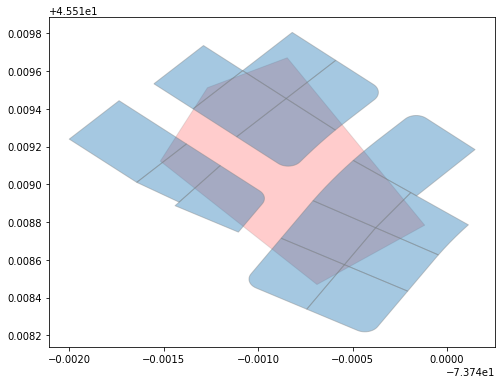

In [57]:
# Check that the results make sense
shape1 = polygons_buildings[polygons_buildings['Poly_Key']==list(polygons_buildings['Poly_Key'][0])[0]]
fig, ax = plt.subplots(figsize = (8,8)) 

shape1['geometry'].iloc[0:1].plot(ax=ax,alpha=0.2, color = 'red', edgecolor='grey')
buildings_clean_gdf['geometry'][list(shape1['index_right'])].plot(ax=ax,alpha=0.4, edgecolor='grey')

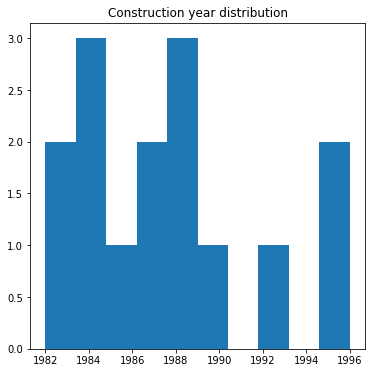

In [62]:
fig, ax = plt.subplots(figsize = (6,6)) 
shape1['ANNEE_CONS'].hist(ax=ax,grid=False);
plt.title('Construction year distribution');

In [63]:
len(polygons_buildings['MATRICULE8'].unique()),len(buildings_clean_gdf['MATRICULE8'].unique())

(355424, 355427)

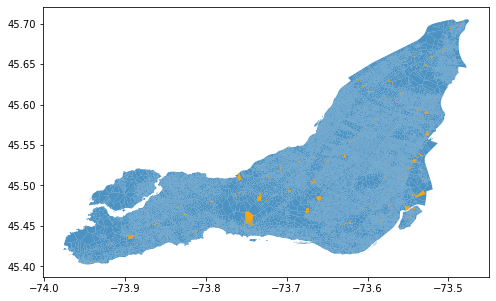

In [64]:
fig, ax = plt.subplots(figsize = (8,8)) 
gdf_left['geometry'].plot(ax=ax,alpha=0.8)
polygons_buildings[polygons_buildings['index_right'].isnull()]['geometry'].plot(ax=ax,color='orange')

In [65]:
polygons_buildings2 = pd.get_dummies(polygons_buildings,columns=['CATEGORIE_'])
polygons_buildings2 = polygons_buildings2.rename(columns={"CATEGORIE__Régulier":"Num_Regular", "CATEGORIE__Condominium":"Num_Condo"})
polygons_buildings2['Num_logement'] = polygons_buildings2['LIBELLE_UT'].apply(lambda x: 1 if x=='Logement' else 0)
polygons_buildings2.head()

,Polygon,Intersection,Borough,CFSAUID,Poly_Key,geometry,index_right,CIVIQUE_DE,CIVIQUE_FI,NOM_RUE,NOMBRE_LOG,ANNEE_CONS,LIBELLE_UT,SUPERFICIE,MATRICULE8,condo_combined,building_poly,centroid,Num_Condo,CATEGORIE__Infrastructure,Num_Regular,Num_logement
0,"POLYGON ((-73.74012 45.51879, -73.74069 45.518...",POINT (-73.74082 45.51897),Ahuntsic-Cartierville,H4K,POLYGON ((-73.74012023460041 45.51878665964649...,"POLYGON ((-73.74012 45.51879, -73.74069 45.518...",43865.0,12323,12323,avenue Adhémar-Mailhiot (MTL),1.0,1993.0,Logement,743.0,8542-91-6495-8-000-0000,1.0,"POLYGON ((-73.74108 45.51960, -73.74085 45.519...",POINT (-73.74110 45.51943),0,0,1,1
0,"POLYGON ((-73.74012 45.51879, -73.74069 45.518...",POINT (-73.74082 45.51897),Ahuntsic-Cartierville,H4K,POLYGON ((-73.74012023460041 45.51878665964649...,"POLYGON ((-73.74012 45.51879, -73.74069 45.518...",42273.0,12280,12280,avenue Antoine-Berthelet (MTL),1.0,1987.0,Logement,829.0,8642-02-0400-9-000-0000,1.0,"POLYGON ((-73.74059 45.51929, -73.74085 45.519...",POINT (-73.74059 45.51947),0,0,1,1
0,"POLYGON ((-73.74012 45.51879, -73.74069 45.518...",POINT (-73.74082 45.51897),Ahuntsic-Cartierville,H4K,POLYGON ((-73.74012023460041 45.51878665964649...,"POLYGON ((-73.74012 45.51879, -73.74069 45.518...",44206.0,12335,12335,avenue Adhémar-Mailhiot (MTL),1.0,1988.0,Logement,669.0,8542-92-4711-8-000-0000,1.0,"POLYGON ((-73.74155 45.51953, -73.74129 45.519...",POINT (-73.74132 45.51957),0,0,1,1
0,"POLYGON ((-73.74012 45.51879, -73.74069 45.518...",POINT (-73.74082 45.51897),Ahuntsic-Cartierville,H4K,POLYGON ((-73.74012023460041 45.51878665964649...,"POLYGON ((-73.74012 45.51879, -73.74069 45.518...",42606.0,12290,12290,avenue Antoine-Berthelet (MTL),1.0,1984.0,Logement,743.0,8542-92-8518-3-000-0000,1.0,"POLYGON ((-73.74085 45.51946, -73.74108 45.519...",POINT (-73.74084 45.51963),0,0,1,1
0,"POLYGON ((-73.74012 45.51879, -73.74069 45.518...",POINT (-73.74082 45.51897),Ahuntsic-Cartierville,H4K,POLYGON ((-73.74012023460041 45.51878665964649...,"POLYGON ((-73.74012 45.51879, -73.74069 45.518...",339330.0,9081,9081,rue Paul-Morand (MTL),1.0,1996.0,Logement,773.0,8542-91-5739-0-000-0000,1.0,"POLYGON ((-73.74120 45.51910, -73.74099 45.518...",POINT (-73.74118 45.51892),0,0,1,1


In [0]:
polygons_buildings2['Num_buildings'] = polygons_buildings2['MATRICULE8']
polygons_buildings2['Num_units_sum'] = polygons_buildings2['NOMBRE_LOG']
polygons_buildings2['Num_units_avg'] = polygons_buildings2['NOMBRE_LOG']
polygons_buildings2['Num_units_median'] = polygons_buildings2['NOMBRE_LOG']
polygons_buildings2['Num_units_max'] = polygons_buildings2['NOMBRE_LOG']
polygons_buildings2['Construction_Year_min'] = polygons_buildings2['ANNEE_CONS']
polygons_buildings2['Construction_Year_max'] = polygons_buildings2['ANNEE_CONS']
polygons_buildings2['Construction_Year_avg'] = polygons_buildings2['ANNEE_CONS']
polygons_buildings2['Construction_Year_median'] = polygons_buildings2['ANNEE_CONS']
polygons_buildings2['Building_area_min'] = polygons_buildings2['SUPERFICIE']
polygons_buildings2['Building_area_max'] = polygons_buildings2['SUPERFICIE']
polygons_buildings2['Building_area_avg'] = polygons_buildings2['SUPERFICIE']

In [67]:
# Group by polygon
polygons_buildings_agg = polygons_buildings2.groupby(['Poly_Key','Borough','CFSAUID']).agg({
    'Num_buildings': 'count',
    'Num_Regular': 'sum',
    'Num_Condo': 'sum',
    'Num_logement': 'sum',
    'Num_units_sum': 'sum',
    'Num_units_avg': 'mean',
    'Num_units_median': 'median',
    'Num_units_max': 'max',
    'Construction_Year_min': 'min',
    'Construction_Year_max': 'max',
    'Construction_Year_avg': 'mean',
    'Construction_Year_median': 'median',
    'Building_area_min': 'min',
    'Building_area_max': 'max',
    'Building_area_avg': 'mean',
}).reset_index()
num_cols = ['Num_Condo','Num_Regular','Num_logement','Num_buildings','Num_units_sum','Num_units_avg','Num_units_median','Num_units_max',
            'Construction_Year_min','Construction_Year_max','Construction_Year_avg','Construction_Year_median','Building_area_avg']
polygons_buildings_agg[num_cols] = polygons_buildings_agg[num_cols].fillna(0)

len(polygons_buildings_agg),len(polygons_buildings2)

(25139, 615656)

In [68]:
polygons_buildings_agg.head()

,Poly_Key,Borough,CFSAUID,Num_buildings,Num_Regular,Num_Condo,Num_logement,Num_units_sum,Num_units_avg,Num_units_median,Num_units_max,Construction_Year_min,Construction_Year_max,Construction_Year_avg,Construction_Year_median,Building_area_min,Building_area_max,Building_area_avg
0,MULTIPOLYGON (((-73.49148128488116 45.63322546...,Rivière-des-Prairies-Pointe-aux-Trembles,H1B,20,20,0.0,17,45.0,2.250000,2.0,6.0,1900.0,1964.0,1944.850000,1955.5,259.0,2203.0,641.600000
1,MULTIPOLYGON (((-73.49417600555641 45.63484983...,Rivière-des-Prairies-Pointe-aux-Trembles,H1B,14,14,0.0,11,72.0,5.142857,2.0,48.0,1900.0,1979.0,1951.071429,1955.5,259.0,5090.0,1007.642857
2,MULTIPOLYGON (((-73.4974204148789 45.628545266...,Montréal-Est,H1B,15,15,0.0,11,107.0,7.133333,1.0,75.0,1910.0,2016.0,1969.428571,1971.0,418.0,17134.0,2883.066667
3,MULTIPOLYGON (((-73.49743783438723 45.62877001...,Montréal-Est,H1B,17,17,0.0,17,48.0,2.823529,2.0,20.0,1908.0,2000.0,1958.588235,1960.0,351.0,2797.0,803.176471
4,MULTIPOLYGON (((-73.49952224636007 45.62478531...,Montréal-Est,H1B,9,9,0.0,5,7.0,0.777778,1.0,2.0,1890.0,2016.0,1932.125000,1922.0,255.0,23313.0,5920.666667


In [74]:
print(polygons_buildings_agg['Num_buildings'].mean(), polygons_buildings_agg['Num_buildings'].median())

24.472174708620074 19.0


In [0]:
print(len(polygons_buildings_agg[polygons_buildings_agg['Num_buildings']==0]),"out of",len(polygons_buildings_agg),"polygons without buildings")

450 out of 25139 polygons without buildings


In [0]:
polygons_buildings_agg.to_csv(folder+"clean_polygons_buildings+boroughs.csv")

## Join polygons, boroughs, buildings to latest (census) data

In [0]:
# polygons_census = pd.read_csv(folder + "clean_incidents_by_polygon_year_census.csv")
# data_all.head()
data_all = polygons_census
data_all.head()

,Unnamed: 0,Poly_Key,CFSAUID,Year,Building_fire,incident,Desc_gr_clean_Alarmes-incendies,Desc_gr_clean_Autres incendies,Desc_gr_clean_Fausses alertes/annulations,Desc_gr_clean_Nouveau,Desc_gr_clean_Premier répondant,Desc_gr_clean_Sans incendie,Num_units_total,Num_units_mean,Num_units_median,population,total_dwellings,gr_0_to_14_years,gr_15_19_years,gr_20_24_years,gr_25_34_years,gr_35_44_years,gr_45_54_years,gr_55_64_years,gr_65plus_years,gr_married_commomlawpartner,gr_Couples_with_children,gr_Couples_without_children,income_per_capita,Income_0_to_35K,Income_35K_to_70K,Income_70K+,population tax payers
0,0,MULTIPOLYGON (((-73.49148128488116 45.63322546...,H1B,2005,0.0,3.0,0,0,1,0,0.0,2,10.0,3.333333,4.0,20253,8948,0.13,0.08,0.08,0.1,0.11,0.22,0.12,0.0,0.21,0.0,0.11,34781.076809,9440,5220,1520,16170
1,15,MULTIPOLYGON (((-73.49417600555641 45.63484983...,H1B,2005,0.0,0.0,0,0,0,0,0.0,0,0.0,0.000000,0.0,20253,8948,0.13,0.08,0.08,0.1,0.11,0.22,0.12,0.0,0.21,0.0,0.11,34781.076809,9440,5220,1520,16170
2,30,MULTIPOLYGON (((-73.4974204148789 45.628545266...,H1B,2005,0.0,2.0,0,0,0,0,0.0,2,3.0,1.500000,1.5,20253,8948,0.13,0.08,0.08,0.1,0.11,0.22,0.12,0.0,0.21,0.0,0.11,34781.076809,9440,5220,1520,16170
3,45,MULTIPOLYGON (((-73.49743783438723 45.62877001...,H1B,2005,0.0,3.0,1,0,0,0,0.0,2,7.0,2.333333,1.0,20253,8948,0.13,0.08,0.08,0.1,0.11,0.22,0.12,0.0,0.21,0.0,0.11,34781.076809,9440,5220,1520,16170
4,60,MULTIPOLYGON (((-73.49952224636007 45.62478531...,H1B,2005,0.0,0.0,0,0,0,0,0.0,0,0.0,0.000000,0.0,20253,8948,0.13,0.08,0.08,0.1,0.11,0.22,0.12,0.0,0.21,0.0,0.11,34781.076809,9440,5220,1520,16170


In [0]:
data_all = data_all.rename(columns={'Num_units_mean':'Num_trucks_mean','Num_units_median':'Num_trucks_median','Num_units_total':'Num_trucks_total'})

In [0]:
# If data already exists
data_all = data_all.drop(['Borough', 'Num_buildings', 'Num_Regular', 'Num_Condo', 'Num_logement', 'Num_units_sum', 'Num_units_avg', 'Num_units_median', 'Num_units_max', 'Construction_Year_min',
                           'Construction_Year_max', 'Construction_Year_avg', 'Construction_Year_median', 'Building_area_min', 'Building_area_max', 'Building_area_avg'],axis=1,errors='ignore')
data_all.head()

,Unnamed: 0,Poly_Key,CFSAUID,Year,Building_fire,incident,Desc_gr_clean_Alarmes-incendies,Desc_gr_clean_Autres incendies,Desc_gr_clean_Fausses alertes/annulations,Desc_gr_clean_Nouveau,Desc_gr_clean_Premier répondant,Desc_gr_clean_Sans incendie,Num_trucks_total,Num_trucks_mean,Num_trucks_median,population,total_dwellings,gr_0_to_14_years,gr_15_19_years,gr_20_24_years,gr_25_34_years,gr_35_44_years,gr_45_54_years,gr_55_64_years,gr_65plus_years,gr_married_commomlawpartner,gr_Couples_with_children,gr_Couples_without_children,income_per_capita,Income_0_to_35K,Income_35K_to_70K,Income_70K+,population tax payers
0,0,MULTIPOLYGON (((-73.49148128488116 45.63322546...,H1B,2005,0.0,3.0,0,0,1,0,0.0,2,10.0,3.333333,4.0,20253,8948,0.13,0.08,0.08,0.1,0.11,0.22,0.12,0.0,0.21,0.0,0.11,34781.076809,9440,5220,1520,16170
1,15,MULTIPOLYGON (((-73.49417600555641 45.63484983...,H1B,2005,0.0,0.0,0,0,0,0,0.0,0,0.0,0.000000,0.0,20253,8948,0.13,0.08,0.08,0.1,0.11,0.22,0.12,0.0,0.21,0.0,0.11,34781.076809,9440,5220,1520,16170
2,30,MULTIPOLYGON (((-73.4974204148789 45.628545266...,H1B,2005,0.0,2.0,0,0,0,0,0.0,2,3.0,1.500000,1.5,20253,8948,0.13,0.08,0.08,0.1,0.11,0.22,0.12,0.0,0.21,0.0,0.11,34781.076809,9440,5220,1520,16170
3,45,MULTIPOLYGON (((-73.49743783438723 45.62877001...,H1B,2005,0.0,3.0,1,0,0,0,0.0,2,7.0,2.333333,1.0,20253,8948,0.13,0.08,0.08,0.1,0.11,0.22,0.12,0.0,0.21,0.0,0.11,34781.076809,9440,5220,1520,16170
4,60,MULTIPOLYGON (((-73.49952224636007 45.62478531...,H1B,2005,0.0,0.0,0,0,0,0,0.0,0,0.0,0.000000,0.0,20253,8948,0.13,0.08,0.08,0.1,0.11,0.22,0.12,0.0,0.21,0.0,0.11,34781.076809,9440,5220,1520,16170


In [0]:
data_all_joined = data_all.merge(polygons_buildings_agg,how='left',left_on = 'Poly_Key', right_on = 'Poly_Key',suffixes=('','_y'))
data_all_joined.head()

,Unnamed: 0,Poly_Key,CFSAUID,Year,Building_fire,incident,Desc_gr_clean_Alarmes-incendies,Desc_gr_clean_Autres incendies,Desc_gr_clean_Fausses alertes/annulations,Desc_gr_clean_Nouveau,Desc_gr_clean_Premier répondant,Desc_gr_clean_Sans incendie,Num_trucks_total,Num_trucks_mean,Num_trucks_median,population,total_dwellings,gr_0_to_14_years,gr_15_19_years,gr_20_24_years,gr_25_34_years,gr_35_44_years,gr_45_54_years,gr_55_64_years,gr_65plus_years,gr_married_commomlawpartner,gr_Couples_with_children,gr_Couples_without_children,income_per_capita,Income_0_to_35K,Income_35K_to_70K,Income_70K+,population tax payers,Borough,CFSAUID_y,Num_buildings,Num_Regular,Num_Condo,Num_logement,Num_units_sum,Num_units_avg,Num_units_median,Num_units_max,Construction_Year_min,Construction_Year_max,Construction_Year_avg,Construction_Year_median,Building_area_min,Building_area_max,Building_area_avg
0,0,MULTIPOLYGON (((-73.49148128488116 45.63322546...,H1B,2005,0.0,3.0,0,0,1,0,0.0,2,10.0,3.333333,4.0,20253,8948,0.13,0.08,0.08,0.1,0.11,0.22,0.12,0.0,0.21,0.0,0.11,34781.076809,9440,5220,1520,16170,Rivière-des-Prairies-Pointe-aux-Trembles,H1B,20.0,20.0,0.0,17.0,45.0,2.250000,2.0,6.0,1900.0,1964.0,1944.850000,1955.5,259.0,2203.0,641.600000
1,15,MULTIPOLYGON (((-73.49417600555641 45.63484983...,H1B,2005,0.0,0.0,0,0,0,0,0.0,0,0.0,0.000000,0.0,20253,8948,0.13,0.08,0.08,0.1,0.11,0.22,0.12,0.0,0.21,0.0,0.11,34781.076809,9440,5220,1520,16170,Rivière-des-Prairies-Pointe-aux-Trembles,H1B,14.0,14.0,0.0,11.0,72.0,5.142857,2.0,48.0,1900.0,1979.0,1951.071429,1955.5,259.0,5090.0,1007.642857
2,30,MULTIPOLYGON (((-73.4974204148789 45.628545266...,H1B,2005,0.0,2.0,0,0,0,0,0.0,2,3.0,1.500000,1.5,20253,8948,0.13,0.08,0.08,0.1,0.11,0.22,0.12,0.0,0.21,0.0,0.11,34781.076809,9440,5220,1520,16170,Montréal-Est,H1B,15.0,15.0,0.0,11.0,107.0,7.133333,1.0,75.0,1910.0,2016.0,1969.428571,1971.0,418.0,17134.0,2883.066667
3,45,MULTIPOLYGON (((-73.49743783438723 45.62877001...,H1B,2005,0.0,3.0,1,0,0,0,0.0,2,7.0,2.333333,1.0,20253,8948,0.13,0.08,0.08,0.1,0.11,0.22,0.12,0.0,0.21,0.0,0.11,34781.076809,9440,5220,1520,16170,Montréal-Est,H1B,17.0,17.0,0.0,17.0,48.0,2.823529,2.0,20.0,1908.0,2000.0,1958.588235,1960.0,351.0,2797.0,803.176471
4,60,MULTIPOLYGON (((-73.49952224636007 45.62478531...,H1B,2005,0.0,0.0,0,0,0,0,0.0,0,0.0,0.000000,0.0,20253,8948,0.13,0.08,0.08,0.1,0.11,0.22,0.12,0.0,0.21,0.0,0.11,34781.076809,9440,5220,1520,16170,Montréal-Est,H1B,9.0,9.0,0.0,5.0,7.0,0.777778,1.0,2.0,1890.0,2016.0,1932.125000,1922.0,255.0,23313.0,5920.666667


In [0]:
# Remove rows with polygon that is null
data_all_joined = data_all_joined[data_all_joined['Poly_Key'] !='None']
data_all_joined = data_all_joined[~data_all_joined['Poly_Key'].isnull()]
print(len(data_all),len(data_all_joined),len(data_all_joined[data_all_joined['CFSAUID_y'].isnull()]))
data_all_joined = data_all_joined.drop(['Unnamed: 0','CFSAUID_y'],axis=1,errors='ignore')

377100 377085 0


In [0]:
data_all_joined.head()

,Poly_Key,CFSAUID,Year,Building_fire,incident,Desc_gr_clean_Alarmes-incendies,Desc_gr_clean_Autres incendies,Desc_gr_clean_Fausses alertes/annulations,Desc_gr_clean_Nouveau,Desc_gr_clean_Premier répondant,Desc_gr_clean_Sans incendie,Num_trucks_total,Num_trucks_mean,Num_trucks_median,population,total_dwellings,gr_0_to_14_years,gr_15_19_years,gr_20_24_years,gr_25_34_years,gr_35_44_years,gr_45_54_years,gr_55_64_years,gr_65plus_years,gr_married_commomlawpartner,gr_Couples_with_children,gr_Couples_without_children,income_per_capita,Income_0_to_35K,Income_35K_to_70K,Income_70K+,population tax payers,Borough,Num_buildings,Num_Regular,Num_Condo,Num_logement,Num_units_sum,Num_units_avg,Num_units_median,Num_units_max,Construction_Year_min,Construction_Year_max,Construction_Year_avg,Construction_Year_median,Building_area_min,Building_area_max,Building_area_avg
0,MULTIPOLYGON (((-73.49148128488116 45.63322546...,H1B,2005,0.0,3.0,0,0,1,0,0.0,2,10.0,3.333333,4.0,20253,8948,0.13,0.08,0.08,0.1,0.11,0.22,0.12,0.0,0.21,0.0,0.11,34781.076809,9440,5220,1520,16170,Rivière-des-Prairies-Pointe-aux-Trembles,20.0,20.0,0.0,17.0,45.0,2.250000,2.0,6.0,1900.0,1964.0,1944.850000,1955.5,259.0,2203.0,641.600000
1,MULTIPOLYGON (((-73.49417600555641 45.63484983...,H1B,2005,0.0,0.0,0,0,0,0,0.0,0,0.0,0.000000,0.0,20253,8948,0.13,0.08,0.08,0.1,0.11,0.22,0.12,0.0,0.21,0.0,0.11,34781.076809,9440,5220,1520,16170,Rivière-des-Prairies-Pointe-aux-Trembles,14.0,14.0,0.0,11.0,72.0,5.142857,2.0,48.0,1900.0,1979.0,1951.071429,1955.5,259.0,5090.0,1007.642857
2,MULTIPOLYGON (((-73.4974204148789 45.628545266...,H1B,2005,0.0,2.0,0,0,0,0,0.0,2,3.0,1.500000,1.5,20253,8948,0.13,0.08,0.08,0.1,0.11,0.22,0.12,0.0,0.21,0.0,0.11,34781.076809,9440,5220,1520,16170,Montréal-Est,15.0,15.0,0.0,11.0,107.0,7.133333,1.0,75.0,1910.0,2016.0,1969.428571,1971.0,418.0,17134.0,2883.066667
3,MULTIPOLYGON (((-73.49743783438723 45.62877001...,H1B,2005,0.0,3.0,1,0,0,0,0.0,2,7.0,2.333333,1.0,20253,8948,0.13,0.08,0.08,0.1,0.11,0.22,0.12,0.0,0.21,0.0,0.11,34781.076809,9440,5220,1520,16170,Montréal-Est,17.0,17.0,0.0,17.0,48.0,2.823529,2.0,20.0,1908.0,2000.0,1958.588235,1960.0,351.0,2797.0,803.176471
4,MULTIPOLYGON (((-73.49952224636007 45.62478531...,H1B,2005,0.0,0.0,0,0,0,0,0.0,0,0.0,0.000000,0.0,20253,8948,0.13,0.08,0.08,0.1,0.11,0.22,0.12,0.0,0.21,0.0,0.11,34781.076809,9440,5220,1520,16170,Montréal-Est,9.0,9.0,0.0,5.0,7.0,0.777778,1.0,2.0,1890.0,2016.0,1932.125000,1922.0,255.0,23313.0,5920.666667


In [0]:
data_all_joined.to_csv(folder + "all_data_clean.csv")

In [0]:
data_all_joined[data_all_joined['Num_buildings']==0]['incident'].sum()

9145.0

In [0]:
missing_values = data_all_joined[(data_all_joined['Num_buildings']==0) & (data_all_joined['incident'] > 0) ]
missing_values['Poly_Key'] = missing_values['Poly_Key'].apply(wkt.loads)
missing_values_gdf = gpd.GeoDataFrame(missing_values,geometry = missing_values['Poly_Key'])
missing_values_gdf.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Poly_Key,CFSAUID,Year,Building_fire,incident,Desc_gr_clean_Alarmes-incendies,Desc_gr_clean_Autres incendies,Desc_gr_clean_Fausses alertes/annulations,Desc_gr_clean_Nouveau,Desc_gr_clean_Premier répondant,Desc_gr_clean_Sans incendie,Num_trucks_total,Num_trucks_mean,Num_trucks_median,population,total_dwellings,gr_0_to_14_years,gr_15_19_years,gr_20_24_years,gr_25_34_years,gr_35_44_years,gr_45_54_years,gr_55_64_years,gr_65plus_years,gr_married_commomlawpartner,gr_Couples_with_children,gr_Couples_without_children,income_per_capita,Income_0_to_35K,Income_35K_to_70K,Income_70K+,population tax payers,Borough,Num_buildings,Num_Regular,Num_Condo,Num_logement,Num_units_sum,Num_units_avg,Num_units_median,Num_units_max,Construction_Year_min,Construction_Year_max,Construction_Year_avg,Construction_Year_median,Building_area_min,Building_area_max,Building_area_avg,geometry
4202,"POLYGON ((-73.54656147785226 45.6258188367695,...",H1B,2015,0.0,3.0,0,0,0,0,2.0,1,6.0,2.000000,1.0,20098,9351,0.14,0.05,0.06,0.13,0.12,0.15,0.16,0.36,0.21,0.16,0.11,34440.185185,9510,5260,1450,16200,Montréal-Est,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,"POLYGON ((-73.54656 45.62582, -73.54635 45.626..."
4585,"POLYGON ((-73.54656147785226 45.6258188367695,...",H1B,2016,0.0,3.0,0,1,0,0,1.0,1,5.0,1.666667,1.0,20160,9400,0.14,0.05,0.06,0.13,0.12,0.14,0.16,0.41,0.20,0.10,0.11,35123.235688,9370,5180,1590,16140,Montréal-Est,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,"POLYGON ((-73.54656 45.62582, -73.54635 45.626..."
4968,"POLYGON ((-73.54656147785226 45.6258188367695,...",H1B,2017,0.0,2.0,0,0,0,0,1.0,1,7.0,3.500000,3.5,20221,9445,0.14,0.05,0.06,0.13,0.12,0.14,0.16,0.46,0.20,0.11,0.10,34781.076809,9440,5220,1520,16170,Montréal-Est,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,"POLYGON ((-73.54656 45.62582, -73.54635 45.626..."
5351,"POLYGON ((-73.54656147785226 45.6258188367695,...",H1B,2018,0.0,2.0,0,1,0,0,1.0,0,3.0,1.500000,1.5,20282,9490,0.15,0.05,0.06,0.14,0.12,0.13,0.17,0.50,0.20,0.13,0.10,34781.076809,9440,5220,1520,16170,Montréal-Est,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,"POLYGON ((-73.54656 45.62582, -73.54635 45.626..."
5734,"POLYGON ((-73.54656147785226 45.6258188367695,...",H1B,2019,0.0,3.0,0,0,0,0,3.0,0,5.0,1.666667,2.0,20343,9535,0.16,0.04,0.06,0.14,0.12,0.12,0.17,0.55,0.20,0.14,0.10,34781.076809,9440,5220,1520,16170,Montréal-Est,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,"POLYGON ((-73.54656 45.62582, -73.54635 45.626..."


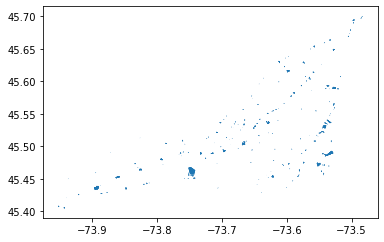

In [0]:
missing_values_gdf['geometry'].plot()